# Case g.c2b6.GJRA.TL319_t061.long_JRA_mct.079

Compset longname is 2000_DATM%JRA_SLND_CICE_MOM6_DROF%JRA_SGLC_SWAV_SIAC_SESP

Baseline (CESM2.2/MOM6 tag) + discontinuos neutral diffusion + Hycom-like Hybrid from OM4

Gustavo Marques (gmarques@ucar.edu)

In [1]:
from datetime import date
print("Last update:", date.today())

Last update: 2020-08-21


## Globally-averaged ocean properties

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
path = '/glade/scratch/gmarques/'
exps = ['g.c2b6.GJRA.TL319_t061.long_JRA_mct.079']
labels = ['G79']

def get_data(full_path, variables):
  def preprocess(ds):
    ''' Return the dataset with variable'''
    return ds[variables]
  ds = xr.open_mfdataset(full_path, data_vars='minimal', \
                         coords='minimal', compat='override', preprocess=preprocess)
  return ds

import seaborn, matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [4]:
# load pre-difined masks
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import ztplot, polarplot, xyplot, xycompare, yzplot
import pop_tools
import cartopy.crs as ccrs
import cartopy.feature
grd = MOM6grid('/glade/scratch/gmarques/'+str(exps[0])+'/run/'+str(exps[0])+'.mom6.static.nc')
grd_xr = MOM6grid('/glade/scratch/gmarques/'+str(exps[0])+'/run/'+str(exps[0])+'.mom6.static.nc', xrformat=True)
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)
grid = pop_tools.get_grid('POP_gx1v7')

Basemap module not found. Some regional plots may not function properly


Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


In [5]:
def pop_add_cyclic(ds):

    nj = ds.TLAT.shape[0]
    ni = ds.TLONG.shape[1]

    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = ds.TLONG.data
    tlat = ds.TLAT.data

    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)
    lon  = np.concatenate((tlon, tlon + 360.), 1)
    lon = lon[:, xL:xR]

    if ni == 320:
        lon[367:-3, 0] = lon[367:-3, 0] + 360.
    lon = lon - 360.

    lon = np.hstack((lon, lon[:, 0:1] + 360.))
    if ni == 320:
        lon[367:, -1] = lon[367:, -1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:, 0] = lon[:, 0] - 1e-8

    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))

    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))

    dso = xr.Dataset({'TLAT': TLAT, 'TLONG': TLONG})

    # copy vars
    varlist = [v for v in ds.data_vars if v not in ['TLAT', 'TLONG']]
    for v in varlist:
        v_dims = ds[v].dims
        if not ('nlat' in v_dims and 'nlon' in v_dims):
            dso[v] = ds[v]
        else:
            # determine and sort other dimensions
            other_dims = set(v_dims) - {'nlat', 'nlon'}
            other_dims = tuple([d for d in v_dims if d in other_dims])
            lon_dim = ds[v].dims.index('nlon')
            field = ds[v].data
            field = np.concatenate((field, field), lon_dim)
            field = field[..., :, xL:xR]
            field = np.concatenate((field, field[..., :, 0:1]), lon_dim)
            dso[v] = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'),
                                  attrs=ds[v].attrs)


    # copy coords
    for v, da in ds.coords.items():
        if not ('nlat' in da.dims and 'nlon' in da.dims):
            dso = dso.assign_coords(**{v: da})


    return dso

In [6]:
grid_o = pop_add_cyclic(grid)

/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079/run/*mom6.hm_*_01.nc


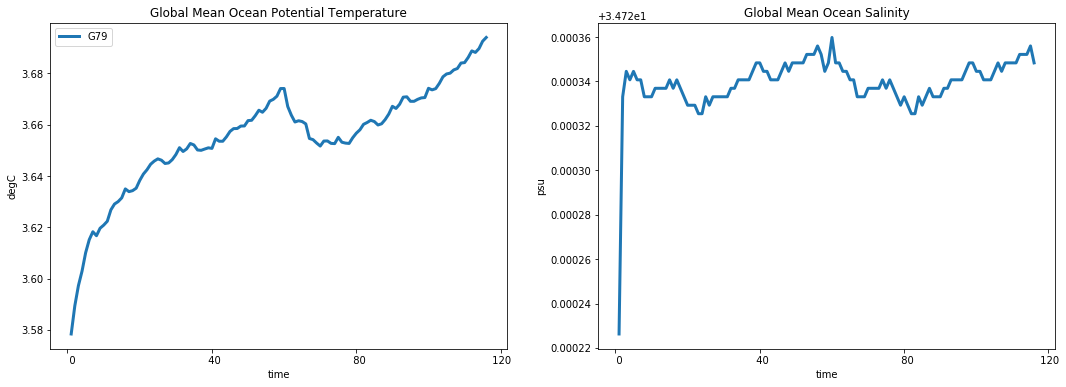

In [7]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variables = ['thetaoga', 'soga']
for i in range(len(exps)):
  # reading just January data
  tmp = path+exps[i]+'/run/*mom6.hm_*_01.nc'
  print(tmp)
  ds = get_data(tmp,variables)
  ds['thetaoga'].plot(ax=ax[0], label=labels[i], lw=3)
  ds['soga'].plot(ax=ax[1], lw=3)

ax[0].set_title(ds.thetaoga.attrs['long_name']); ax[0].set_ylabel(ds.thetaoga.attrs['units'])
ax[1].set_title(ds.soga.attrs['long_name']); ax[1].set_ylabel(ds.soga.attrs['units']); ax[0].legend()

/glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079/run/ocean.stats.nc


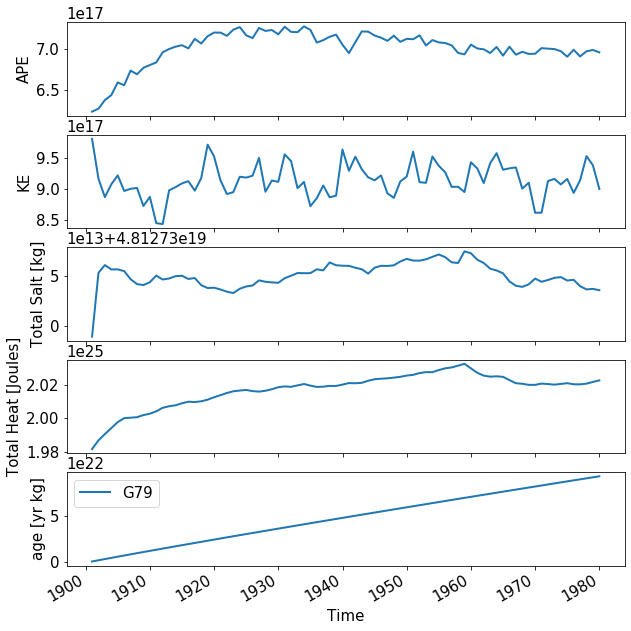

In [8]:
plt.rcParams.update({'font.size': 15})
variables = ['APE', 'KE', 'Salt', 'Heat', 'age']
fig, ax = plt.subplots(nrows=len(variables), ncols=1, figsize=(10,10), sharex=True)
for i in range(len(exps)): 
  path_to_file = path+exps[i]+'/run/ocean.stats.nc'
  print(path_to_file)
  ds = xr.open_dataset(path_to_file)
  time = pd.date_range('1900-01-01', periods=len(ds.Time), freq='D')

  ds['Time'] = time[:]  
  ds1 = ds.resample(Time="1Y", closed='left', keep_attrs=True).mean(dim='Time', keep_attrs=True)   
  ds2 = ds1.sel(Time=slice('1900-01-01', '1980-01-01'))
  for var, j in zip(variables, range(len(variables))):
    if len(ds2[var].shape) > 1:
        tmp = ds2[var].sum(axis=1)
    else:
        tmp = ds2[var]
    tmp.plot(ax=ax[j], label=labels[i], lw=2)
    ax[j].set_xlabel('')
    
ax[j].set_xlabel('Time'); ax[j].legend()

## Mixed layer depth

In [9]:
filepath = '/glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc'
print('\n Reading climatology from: ', filepath)
mld_obs = xr.open_dataset(filepath)
months = [0,1,2]
obs_JFM = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
months = [6,7,8]
obs_JAS = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
obs_winter = obs_JAS.copy(); obs_summer = obs_JAS.copy()
j = np.abs( grd.geolat[:,0] - 0. ).argmin()
obs_winter[j::,:] = obs_JFM[j::,:]
obs_summer[0:j,:] = obs_JFM[0:j,:]

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
def add_labels(ax, nh='JFM', sh='JAS'):
    ax.plot([grd.geolon[0,0], grd.geolon[0,-1]], [0,0], 'k--', lw=0.5)
    ax.text(25, 7, nh, ha="center", va="center", size=12, bbox=bbox_props)
    ax.text(25, -7, sh, ha="center", va="center", size=12, bbox=bbox_props)


 Reading climatology from:  /glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc


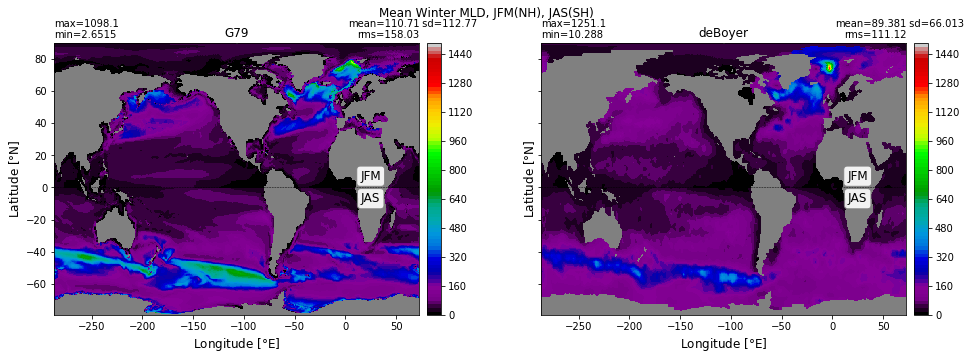

In [10]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Winter MLD, JFM(NH), JAS(SH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_winter.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_winter.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,1500), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i])
  else:
   var = np.ma.masked_invalid(ds.MLD_winter.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,1500),
         colormap=plt.cm.nipy_spectral, nbins=100); add_labels(ax1[i+1])

xyplot(obs_winter, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,1500), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1])

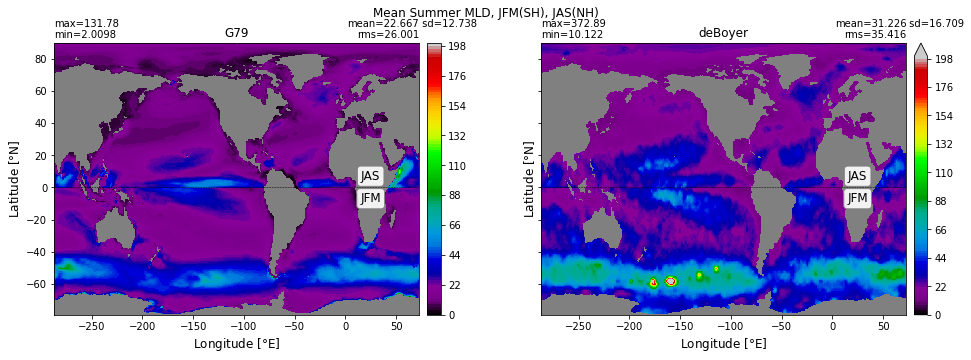

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5), sharex=True, sharey=True)
ax1 = ax.flatten()
plt.suptitle('Mean Summer MLD, JFM(SH), JAS(NH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_summer.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_summer.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i], sh='JFM', nh='JAS')
  else:
   var = np.ma.masked_invalid(ds.MLD_summer.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i+1], sh='JFM', nh='JAS')

xyplot(obs_summer, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,200), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1], sh='JFM', nh='JAS')

## Poleward Heat Transport

</center>
<table>
<tr>
<td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_HeatTransport_global.png'></td>
</tr><tr>
<td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_HeatTransport_Atlantic.png'></td>
</tr><tr>
<td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_HeatTransport_IndoPacific.png'></td>
</tr>
</table>


## Meridional Overturning Circulation

<center> <font size="4">Global</font>
 </center>
<table><tr><td><img  src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_MOC_global.png'></td>
</tr>
</table>

<center> <font size="4">Atlantic</font></center>
<table><tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_MOC_Atlantic.png'></td>
</tr>
</table>

<center> <font size="4">Global GM and FFH</font></center>
<table><tr>
<td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_GM_MOC_global.png'></td>
<td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_FFH_MOC_global.png'></td>
</tr>
</table>

#### Profile @ 26N

<table>
    <tr>
    <td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_MOC_profile_26N.png'></td>
    </tr>   
</table>

#### MOC GM time series between -65 and -30 degN

Text(0.5, 1.0, ' MOC GM, extreme value between -65 and -30 degN')

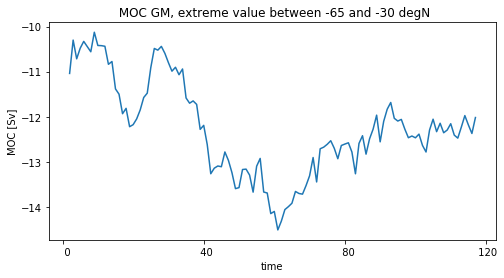

In [12]:
moc = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_MOC.nc')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
moc.moc_GM_ACC.plot(ax=ax)
ax.set_ylabel('MOC [Sv]')
ax.set_title(' MOC GM, extreme value between -65 and -30 degN')

#### AMOC time series @ 26N and 45N

<table>
    <tr>
    <td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_MOC_26N_time_series.png'></td>
    </tr>
    <tr>
    <td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_MOC_45N_time_series.png'></td>
    </tr>    
</table>

## Transports

<table>
    <tr>
    <td><img 
             src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_section_transports.png'></td>
    </tr>  
</table>

## T/S bias at selected vertical levels

In [13]:
# load PHC2 data
phc_path = '/glade/p/cesm/omwg/obs_data/phc/'
phc_temp_mom = xr.open_mfdataset(phc_path+'PHC2_TEMP_tx0.66v1_34lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False)
phc_salt_mom = xr.open_mfdataset(phc_path+'PHC2_SALT_tx0.66v1_34lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False)

phc_temp_pop = pop_add_cyclic(xr.open_dataset(phc_path+'PHC2_TEMP_gx1v7_60lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False).rename({'Y': 'nlat','TEMP':'thetao',
                    'X':'nlon'}).assign_coords({'TLAT': grid.TLAT, 'TLONG':grid.TLONG}).drop('nlat').drop('nlon'))
phc_salt_pop = pop_add_cyclic(xr.open_dataset(phc_path+'PHC2_SALT_gx1v7_60lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False).rename({'Y': 'nlat','SALT':'so',
                    'X':'nlon'}).assign_coords({'TLAT': grid.TLAT, 'TLONG':grid.TLONG}).drop('nlat').drop('nlon'))

In [14]:
def find_nearest(array, value):
    '''Find nearest value and return its indice'''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

#### Temperature

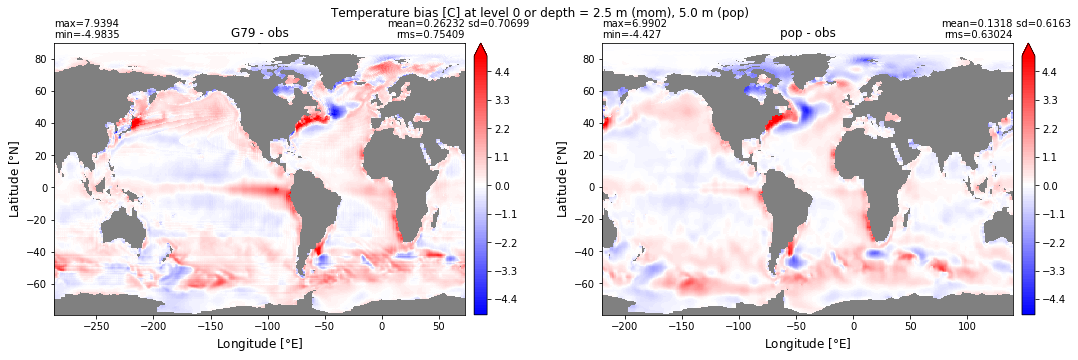

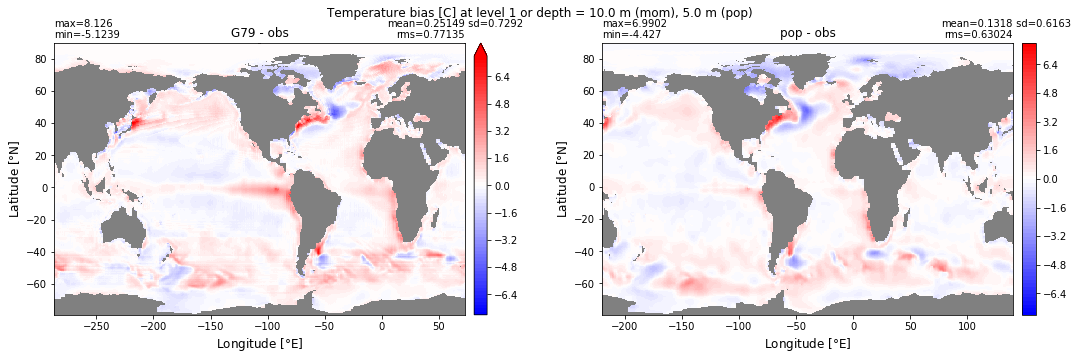

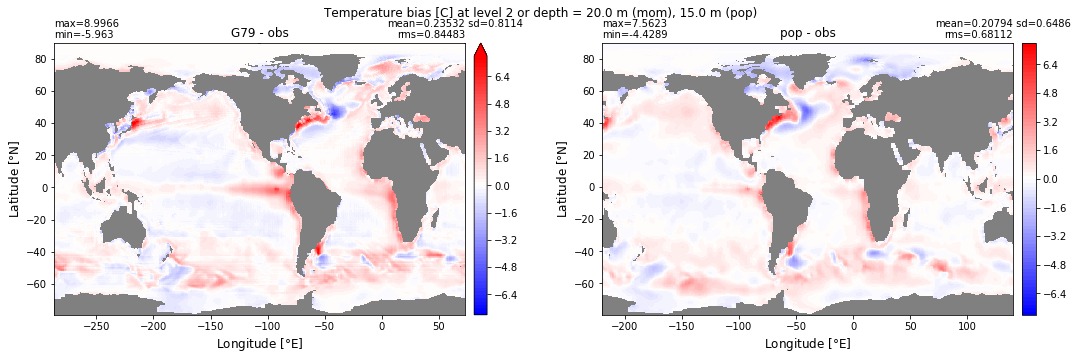

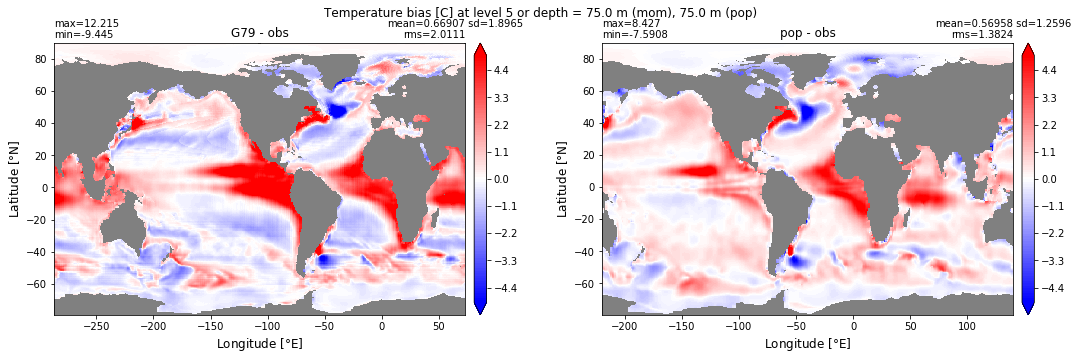

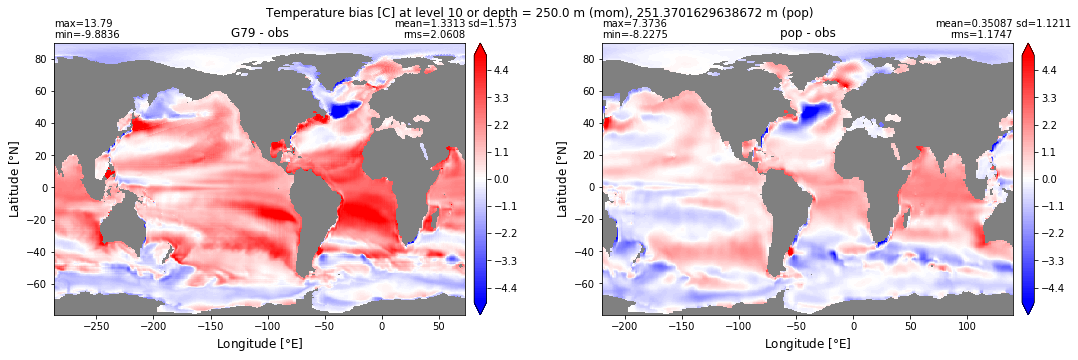

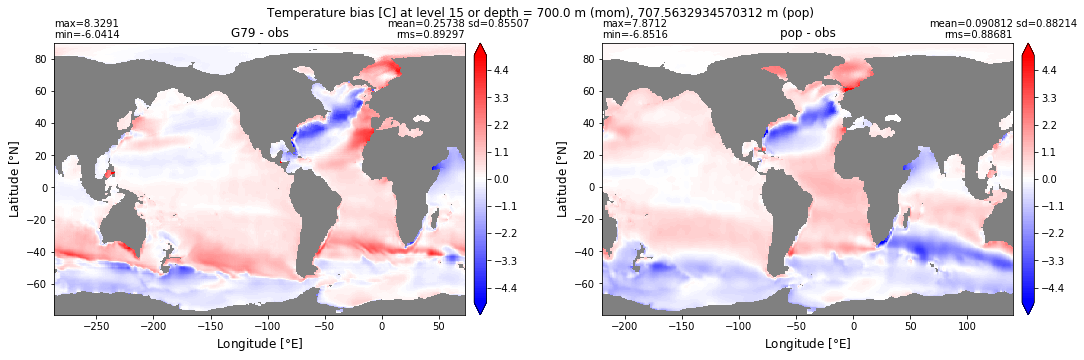

In [15]:
%matplotlib inline
# change k indice to see bias at other depths
levels=[0,1,2,5,10,15,20,25]
ds_mom_t = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_thetao_time_mean.nc')
ds_pop_t = pop_add_cyclic(xr.open_dataset('/glade/scratch/gmarques/g210.GIAF_JRA.v13.gx1v7.01_thetao_time_mean.nc').rename({'yh': 'nlat',
                    'xh':'nlon', 'z_l':'z_t'}).assign_coords({'TLAT': grid.TLAT, 'TLONG':grid.TLONG}).drop('nlat').drop('nlon'))

tlim=[5,7.5,7.5,5,5,5]
for k,t in zip(levels,tlim):
  kpop =  find_nearest(phc_salt_pop.depth.values,phc_temp_mom.depth[k].values) 
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
  ax1 = ax.flatten()
  temp_mom = np.ma.masked_invalid(ds_mom_t.thetao[k,:].values)
  temp_mom_obs = np.ma.masked_invalid(phc_temp_mom['TEMP'][k,:].values)
  temp_pop = ds_pop_t.thetao[kpop,:]
  temp_pop_obs = phc_temp_pop.thetao[kpop,:]
  pop_diff = np.ma.masked_invalid((temp_pop-temp_pop_obs).values)
  
  plt.suptitle('Temperature bias [C] at level {} or depth = {} m (mom), {} m (pop)'.format(k, 
               phc_temp_mom.depth[k].values, phc_temp_pop.depth[kpop].values))
  xyplot(temp_mom-temp_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[0]+' - obs'), axis=ax1[0], 
         clim=(-t,t), nbins=100, colormap=plt.cm.bwr, centerlabels=True)
  xyplot(pop_diff, grid_o.TLONG.values, grid_o.TLAT.values, grid_o.TAREA.values, title=str('pop - obs'), axis=ax1[1], 
         clim=(-t,t), nbins=100, colormap=plt.cm.bwr, centerlabels=True)
  ax1[1].set_xlim(-220,140)
  fname = 'temp_bias_mom_pop_{}'.format(k)
  #plt.savefig(fname+'.png',bbox_inches='tight')

#### Salinity

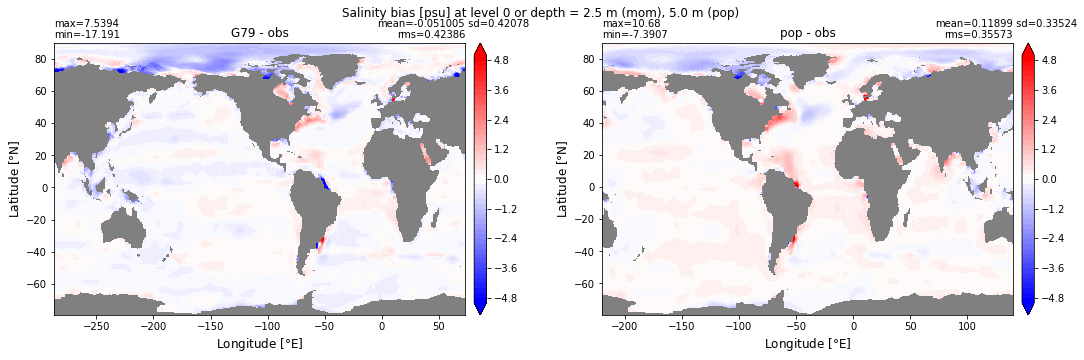

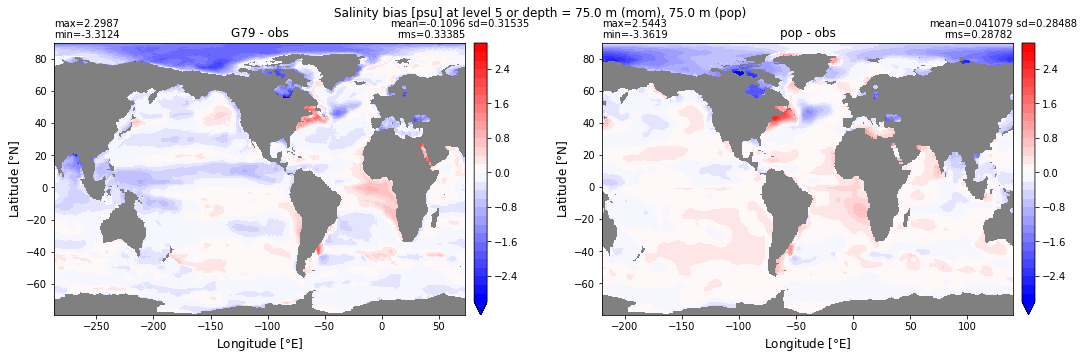

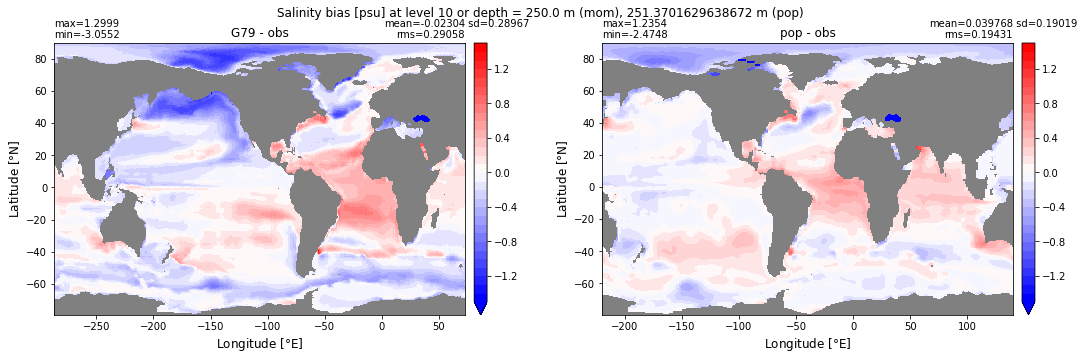

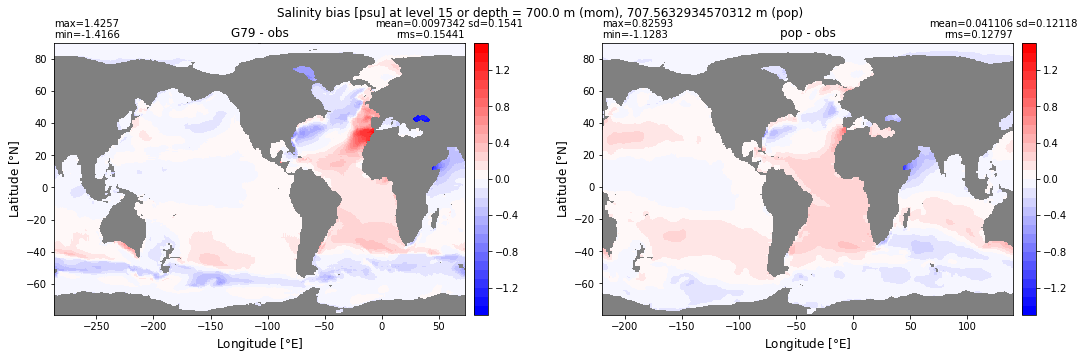

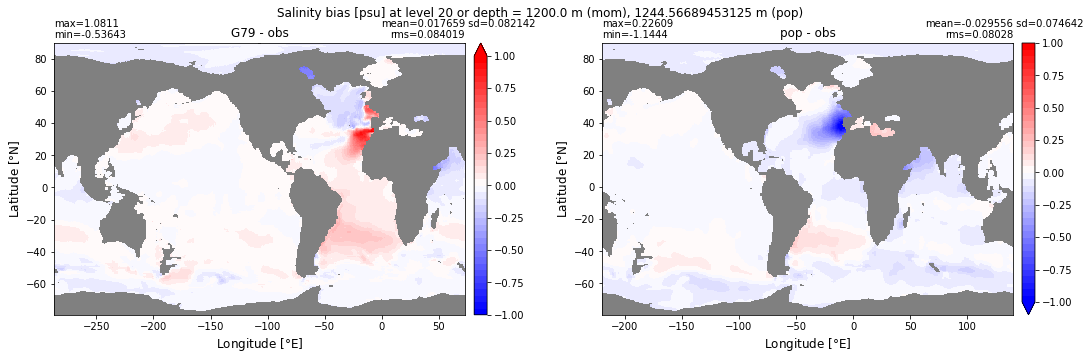

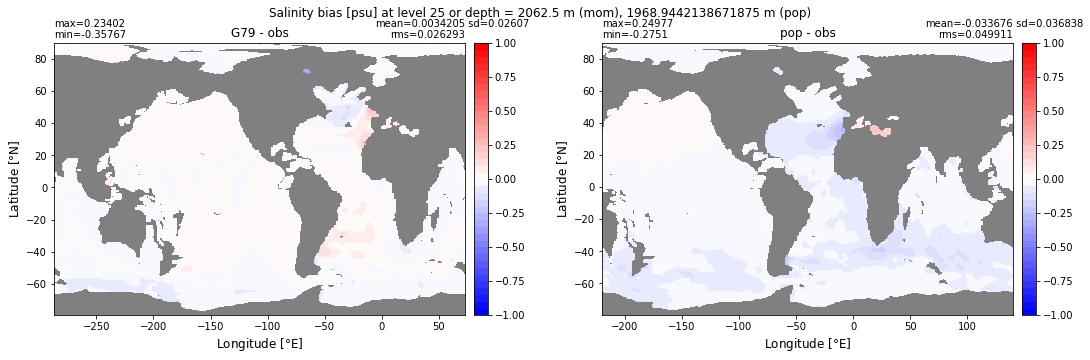

In [16]:
%matplotlib inline
# change k indice to see bias at other depths
levels=[0,5,10,15,20,25]
ds_mom_s = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_so_time_mean.nc')
ds_pop_s = pop_add_cyclic(xr.open_dataset('/glade/scratch/gmarques/g210.GIAF_JRA.v13.gx1v7.01_so_time_mean.nc').rename({'yh': 'nlat',
                    'xh':'nlon', 'z_l':'z_t'}).assign_coords({'TLAT': grid.TLAT, 'TLONG':grid.TLONG}).drop('nlat').drop('nlon'))


slim=[5,3,1.5,1.5,1,1]
for k,s in zip(levels,slim):
  kpop =  find_nearest(phc_salt_pop.depth.values,phc_temp_mom.depth[k].values)  
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,5.))
  ax1 = ax.flatten()
  salt_mom = np.ma.masked_invalid(ds_mom_s.so[k,:].values)
  salt_mom_obs = np.ma.masked_invalid(phc_salt_mom['SALT'][k,:].values)
  salt_pop = ds_pop_s.so[kpop,:]
  salt_pop_obs = phc_salt_pop.so[kpop,:]
  pop_diff = np.ma.masked_invalid((salt_pop-salt_pop_obs).values)

  plt.suptitle('Salinity bias [psu] at level {} or depth = {} m (mom), {} m (pop)'.format(k, 
               phc_salt_mom.depth[k].values, phc_salt_pop.depth[kpop].values))
  xyplot(salt_mom-salt_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[0]+' - obs'), axis=ax1[0], 
         clim=(-s,s), nbins=50, colormap=plt.cm.bwr, centerlabels=True)
  xyplot(pop_diff, grid_o.TLONG.values, grid_o.TLAT.values, grid_o.TAREA.values, title=str('pop - obs'), axis=ax1[1], 
         clim=(-s,s), nbins=50, colormap=plt.cm.bwr, centerlabels=True)
  ax1[1].set_xlim(-220,140)

# Zonally averaged T/S Bias  

### Global

In [17]:
# load these again without renaming variables
phc_temp_pop = pop_add_cyclic(xr.open_dataset(phc_path+'PHC2_TEMP_gx1v7_60lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False))
phc_salt_pop = pop_add_cyclic(xr.open_dataset(phc_path+'PHC2_SALT_gx1v7_60lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False))

ds_pop_s = xr.open_dataset('/glade/scratch/gmarques/g210.GIAF_JRA.v13.gx1v7.01_so_time_mean.nc')
ds_pop_t = xr.open_dataset('/glade/scratch/gmarques/g210.GIAF_JRA.v13.gx1v7.01_thetao_time_mean.nc')

In [18]:
# POP
# reconstruct interfaces
elev_pop = np.concatenate([0,np.diff(ds_pop_t.z_l/100.).cumsum(),6000.], axis=None)
[_, z_pop] = np.meshgrid(grid.TLAT.mean('nlon').values, -elev_pop)
pop_temp_bias = xr.DataArray((ds_pop_t.thetao.values) - (phc_temp_pop.TEMP.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ds_pop_t.z_l, 'yh': ds_pop_t.yh, 'xh':ds_pop_t.xh})
pop_salt_bias = xr.DataArray((ds_pop_s.so.values) - (phc_salt_pop.SALT.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ds_pop_t.z_l, 'yh': ds_pop_t.yh, 'xh':ds_pop_t.xh})
area_pop = grid.TAREA.where(grid.KMT > 0).rename({'nlat':'yh', 'nlon':'xh'})

# construct a 3D area with land values masked
tmp = np.repeat(area_pop.values[np.newaxis, :, :], len(pop_temp_bias.z_l), axis=0)
area_pop3D = xr.DataArray(tmp, dims=('z_l', 'yh','xh'), 
                          coords={'z_l':pop_temp_bias.z_l.values, 'yh': pop_temp_bias.yh.values, 
                                  'xh':pop_temp_bias.xh.values})

KMT = grid.KMT.rename({'nlat':'yh', 'nlon':'xh'})
for k in range(len(area_pop3D.z_l)):
    area_pop3D[k,:] = area_pop.where(KMT >= k) 

In [19]:
# MOM
# reconstruct interfaces
elev_mom = np.concatenate([0,np.diff(ds_mom_t.z_l).cumsum(),6000.], axis=None)
[_, z_mom] = np.meshgrid(ds_mom_t.yh.values, -elev_mom)

mom_temp_bias = xr.DataArray((ds_mom_t.thetao.values) - (phc_temp_mom.TEMP.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ds_mom_t.z_l, 'yh': ds_mom_t.yh, 'xh':ds_mom_t.xh})
mom_salt_bias = xr.DataArray((ds_mom_s.so.values) - (phc_salt_mom.SALT.values), dims=('z_l', 'yh','xh'), 
                             coords={'z_l':ds_mom_t.z_l, 'yh': ds_mom_t.yh, 'xh':ds_mom_t.xh})
area_mom = xr.DataArray(np.ma.masked_where(grd.wet == 0,grd.area_t), dims=('yh','xh'), coords={'yh': ds_mom_t.yh, 'xh':ds_mom_t.xh})

# construct a 3D area with land values masked
area = np.ma.masked_where(grd.wet == 0,grd.area_t)
tmp = np.repeat(area[np.newaxis, :, :], len(mom_temp_bias.z_l), axis=0)
area_mom3D = xr.DataArray(tmp, dims=('z_l', 'yh','xh'), 
                          coords={'z_l':mom_temp_bias.z_l.values, 'yh': mom_temp_bias.yh.values, 
                                  'xh':mom_temp_bias.xh.values})
for k in range(len(area_mom3D.z_l)):
    area_mom3D[k,:] = grd_xr.area_t.where(grd_xr.depth_ocean >= area_mom3D.z_l[k]) 

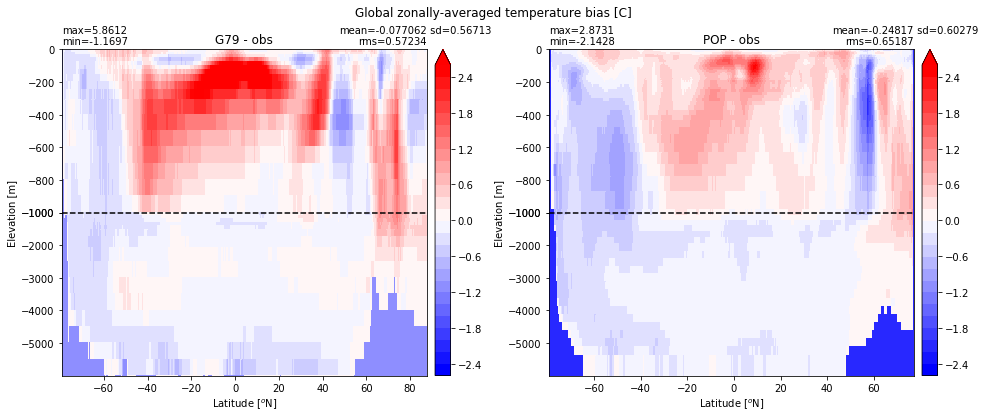

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Global zonally-averaged temperature bias [C]')

mom_temp_global = ((mom_temp_bias * area_mom3D).sum('xh')/area_mom3D.sum('xh'))
pop_temp_global = ((pop_temp_bias * area_pop3D).sum('xh')/area_pop3D.sum('xh'))

yzplot(np.ma.masked_invalid(mom_temp_global), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-2.5, 2.5), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[0].invert_yaxis()

yzplot(np.ma.masked_invalid(pop_temp_global), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-2.5,2.5), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[1].invert_yaxis()

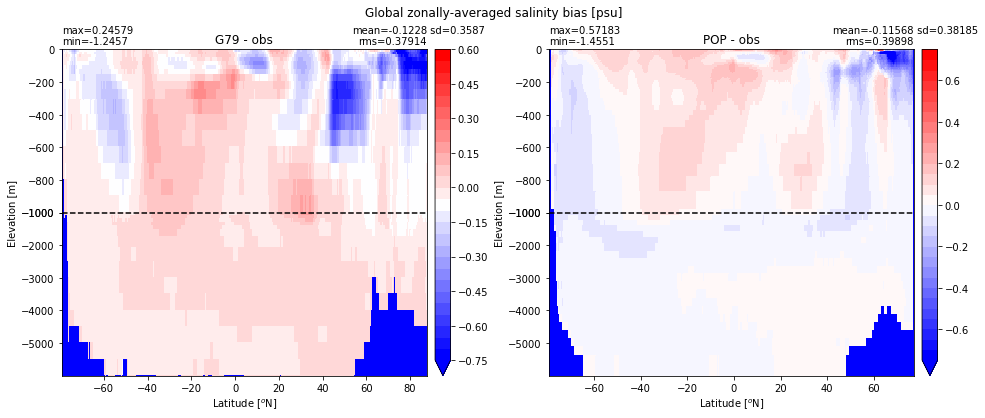

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Global zonally-averaged salinity bias [psu]')
mom_salt_global = ((mom_salt_bias * area_mom3D).sum('xh')/area_mom3D.sum('xh'))
pop_salt_global = ((pop_salt_bias * area_pop3D).sum('xh')/area_pop3D.sum('xh'))

yzplot(np.ma.masked_invalid(mom_salt_global), ds_mom_s.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.75, 0.57), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[0].invert_yaxis()
yzplot(np.ma.masked_invalid(pop_salt_global), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-0.75, 0.75), centerlabels=True, splitscale=[0, -1000,-6000]); ax1[1].invert_yaxis()

### Atlantic

In [22]:
# POP
# mask #6
mask_pop_atl = (grid.REGION_MASK.where(grid.REGION_MASK==6)/6.).rename({'nlon': 'xh','nlat': 'yh'})

pop_temp_alt = ((pop_temp_bias * area_pop3D * mask_pop_atl).sum('xh')/
                (area_pop3D*mask_pop_atl).sum('xh'))
pop_salt_alt = ((pop_salt_bias * area_pop3D * mask_pop_atl).sum('xh')/
                (area_pop3D*mask_pop_atl).sum('xh'))

# MOM
mom_temp_alt = ((basin_code.sel(region='AtlanticOcean')*mom_temp_bias * area_mom3D).sum('xh')/
                (area_mom3D*basin_code.sel(region='AtlanticOcean')).sum('xh'))
mom_salt_alt = ((basin_code.sel(region='AtlanticOcean')*mom_salt_bias * area_mom3D).sum('xh')/
                (area_mom3D*basin_code.sel(region='AtlanticOcean')).sum('xh'))

(-41, 75)

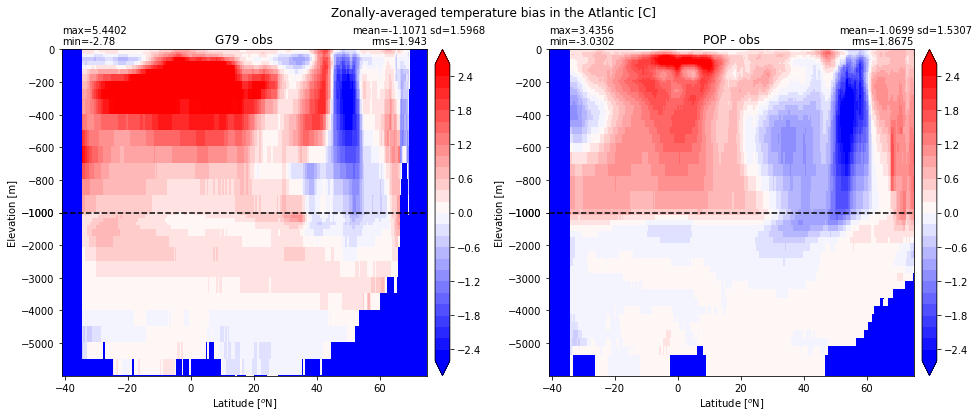

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Zonally-averaged temperature bias in the Atlantic [C]')
yzplot(np.ma.masked_invalid(mom_temp_alt.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-2.5, 2.5), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-41,75)
yzplot(np.ma.masked_invalid(pop_temp_alt), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-2.5,2.5), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-41,75)

(-41, 75)

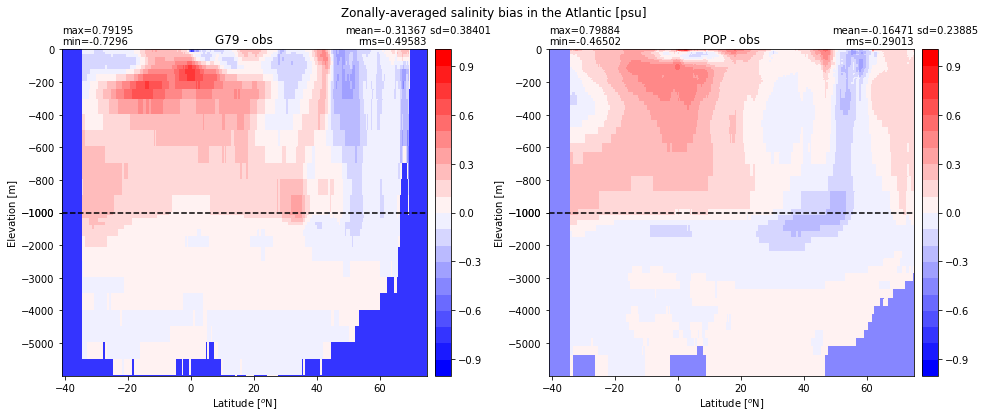

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Zonally-averaged salinity bias in the Atlantic [psu]')

yzplot(np.ma.masked_invalid(mom_salt_alt.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-1, 1), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-41,75)
yzplot(np.ma.masked_invalid(pop_salt_alt), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-1, 1), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-41,75)

### Pacific

In [25]:
# POP
# mask #2
mask_pop_pac = (grid.REGION_MASK.where(grid.REGION_MASK==2)/2.).rename({'nlon': 'xh','nlat': 'yh'})
pop_temp_pac = ((pop_temp_bias * area_pop3D * mask_pop_pac).sum('xh')/
                (area_pop3D*mask_pop_pac).sum('xh'))
pop_salt_pac = ((pop_salt_bias * area_pop3D * mask_pop_pac).sum('xh')/
                (area_pop3D*mask_pop_pac).sum('xh'))

# MOM
mom_temp_pac = ((basin_code.sel(region='PacificOcean')*mom_temp_bias * area_mom3D).sum('xh')/
                (area_mom3D*basin_code.sel(region='PacificOcean')).sum('xh'))
mom_salt_pac = ((basin_code.sel(region='PacificOcean')*mom_salt_bias * area_mom3D).sum('xh')/
                (area_mom3D*basin_code.sel(region='PacificOcean')).sum('xh'))

(-41, 62)

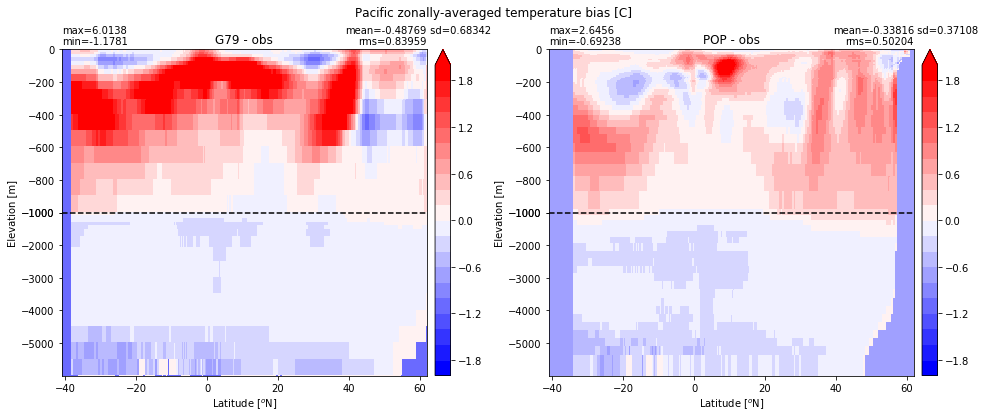

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Pacific zonally-averaged temperature bias [C]')
yzplot(np.ma.masked_invalid(mom_temp_pac.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-2, 2), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-41,62)
yzplot(np.ma.masked_invalid(pop_temp_pac), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-2,2), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-41,62)

(-41, 62)

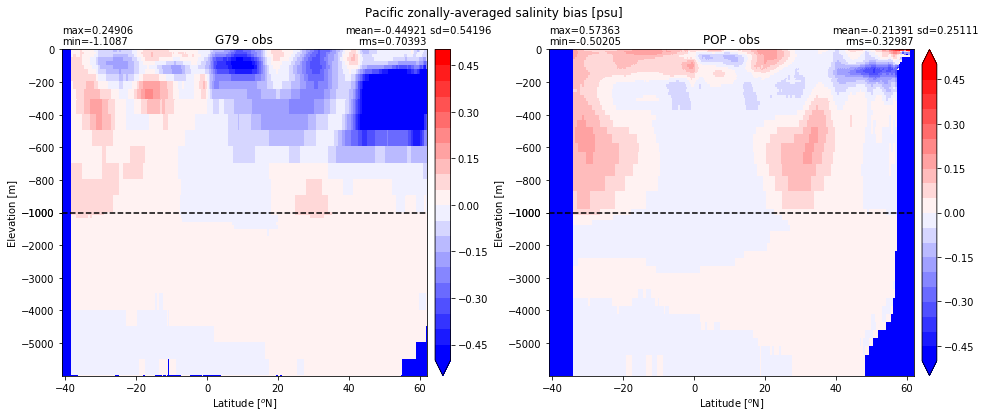

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Pacific zonally-averaged salinity bias [psu]')
yzplot(np.ma.masked_invalid(mom_salt_pac.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.5, 0.5), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-41,62)
yzplot(np.ma.masked_invalid(pop_salt_pac), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-0.5, 0.5), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-41,62)

### Southern Ocean

In [28]:
# POP
# mask #1
mask_pop_so = (grid.REGION_MASK.where(grid.REGION_MASK==1)).rename({'nlon': 'xh','nlat': 'yh'})
pop_temp_so = ((pop_temp_bias * area_pop3D * mask_pop_so).sum('xh')/
               (area_pop3D*mask_pop_so).sum('xh'))
pop_salt_so = ((pop_salt_bias * area_pop3D * mask_pop_so).sum('xh')/
               (area_pop3D*mask_pop_so).sum('xh'))

# MOM
mom_temp_so = ((basin_code.sel(region='SouthernOcean')*mom_temp_bias * area_mom3D).sum('xh')/
               (area_mom3D*basin_code.sel(region='SouthernOcean')).sum('xh'))
mom_salt_so = ((basin_code.sel(region='SouthernOcean')*mom_salt_bias * area_mom3D).sum('xh')/
               (area_mom3D*basin_code.sel(region='SouthernOcean')).sum('xh'))

(-75, -32)

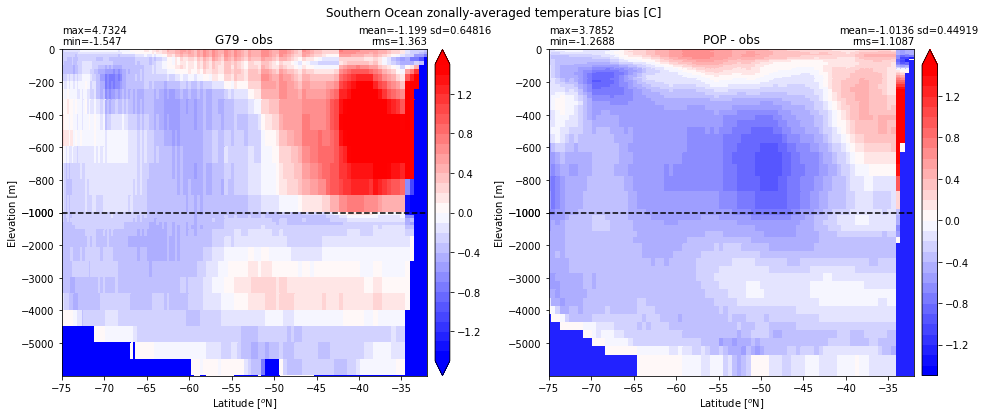

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Southern Ocean zonally-averaged temperature bias [C]')
yzplot(np.ma.masked_invalid(mom_temp_so.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-1.5, 1.5), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-75,-32)
yzplot(np.ma.masked_invalid(pop_temp_so), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-1.5,1.5), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-75,-32)

(-75, -32)

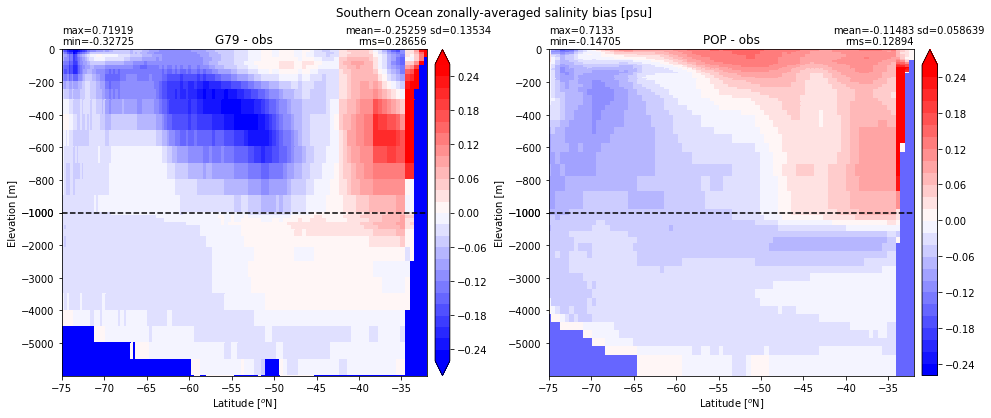

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Southern Ocean zonally-averaged salinity bias [psu]')
yzplot(np.ma.masked_invalid(mom_salt_so.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-0.25, 0.25), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-75,-32)
yzplot(np.ma.masked_invalid(pop_salt_so), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-0.25, 0.25), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-75,-32)

### Indian Ocean

In [31]:
# POP
# mask #3
mask_pop_io = (grid.REGION_MASK.where(grid.REGION_MASK==3)/3.).rename({'nlon': 'xh','nlat': 'yh'})
pop_temp_io = ((pop_temp_bias * area_pop3D * mask_pop_io).sum('xh')/
               (area_pop3D*mask_pop_io).sum('xh'))
pop_salt_io = ((pop_salt_bias * area_pop3D * mask_pop_io).sum('xh')/
               (area_pop3D*mask_pop_io).sum('xh'))

# MOM
mom_temp_io = ((basin_code.sel(region='IndianOcean')*mom_temp_bias * area_mom3D).sum('xh')/
               (area_mom3D*basin_code.sel(region='IndianOcean')).sum('xh'))
mom_salt_io = ((basin_code.sel(region='IndianOcean')*mom_salt_bias * area_mom3D).sum('xh')/
               (area_mom3D*basin_code.sel(region='IndianOcean')).sum('xh'))

(-40, 30)

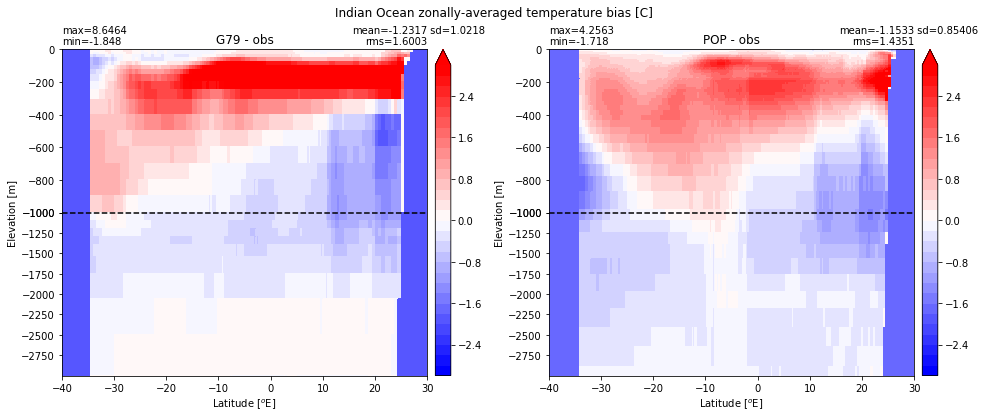

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Indian Ocean zonally-averaged temperature bias [C]')
yzplot(np.ma.masked_invalid(mom_temp_io.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$E', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-3, 3), centerlabels=True, splitscale=[0, -1000,-3000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-40,30)
yzplot(np.ma.masked_invalid(pop_temp_io), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$E', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-3, 3), centerlabels=True, splitscale=[0, -1000,-3000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-40,30)

(-40, 30)

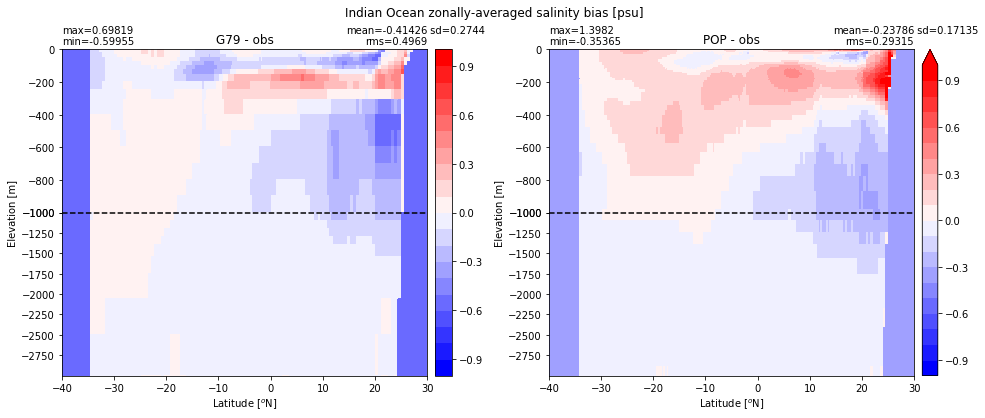

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Indian Ocean zonally-averaged salinity bias [psu]')
yzplot(np.ma.masked_invalid(mom_salt_io.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-1, 1), centerlabels=True, splitscale=[0, -1000,-3000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(-40,30)
yzplot(np.ma.masked_invalid(pop_salt_io), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-1, 1), centerlabels=True, splitscale=[0, -1000,-3000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(-40,30)

### Med Sea

In [34]:
# POP
# mask #7
mask_pop_med = (grid.REGION_MASK.where(grid.REGION_MASK==7)/7.).rename({'nlon': 'xh','nlat': 'yh'})
pop_temp_med = ((pop_temp_bias * area_pop * mask_pop_med).sum('xh')/
                (area_pop3D*mask_pop_med).sum('xh'))
pop_salt_med = ((pop_salt_bias * area_pop * mask_pop_med).sum('xh')/
                (area_pop3D*mask_pop_med).sum('xh'))

# MOM
mom_temp_med = ((basin_code.sel(region='MedSea')*mom_temp_bias * area_mom).sum('xh')/
                (area_mom3D*basin_code.sel(region='MedSea')).sum('xh'))
mom_salt_med = ((basin_code.sel(region='MedSea')*mom_salt_bias * area_mom).sum('xh')/
                (area_mom3D*basin_code.sel(region='MedSea')).sum('xh'))

(30, 48)

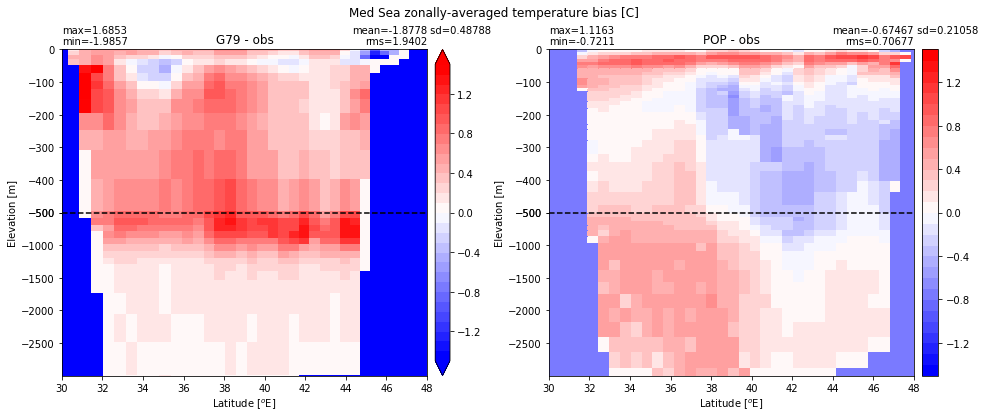

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Med Sea zonally-averaged temperature bias [C]')
yzplot(np.ma.masked_invalid(mom_temp_med.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$E', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-1.5, 1.5), centerlabels=True, splitscale=[0, -500,-3000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(30,48)
yzplot(np.ma.masked_invalid(pop_temp_med), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$E', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-1.5, 1.5), centerlabels=True, splitscale=[0, -500,-3000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(30,48)

(30, 48)

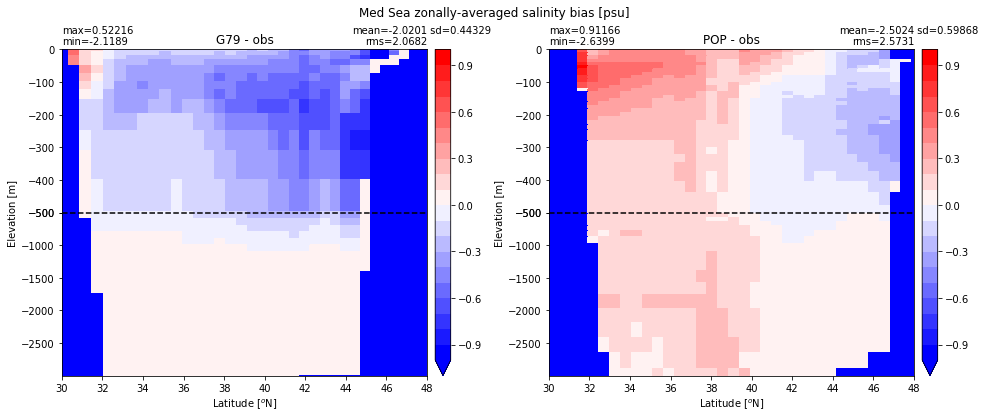

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Med Sea zonally-averaged salinity bias [psu]')
yzplot(np.ma.masked_invalid(mom_salt_med.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-1, 1), centerlabels=True, splitscale=[0, -500,-3000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(30,48)
yzplot(np.ma.masked_invalid(pop_salt_med), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-1, 1), centerlabels=True, splitscale=[0, -500,-3000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(30,48)

### Arctic Ocean

In [37]:
# POP
# combine masks #9 and #10
tmp = np.zeros(grid.REGION_MASK.shape)
tmp[grid.REGION_MASK.values == 9] = 1.0
tmp[grid.REGION_MASK.values == 10] = 1.0
mask_pop_arc = xr.DataArray(tmp, dims=('yh','xh'), 
                             coords={'yh': ds_pop_t.yh, 'xh':ds_pop_t.xh})

pop_temp_arc = ((pop_temp_bias * area_pop * mask_pop_arc).sum('xh')/
                (area_pop3D*mask_pop_arc).sum('xh'))
pop_salt_arc = ((pop_salt_bias * area_pop * mask_pop_arc).sum('xh')/
                (area_pop3D*mask_pop_arc).sum('xh'))

# MOM
mom_temp_arc = ((basin_code.sel(region='Arctic')*mom_temp_bias * area_mom).sum('xh')/
                (area_mom3D*basin_code.sel(region='Arctic')).sum('xh'))
mom_salt_arc = ((basin_code.sel(region='Arctic')*mom_salt_bias * area_mom).sum('xh')/
                (area_mom3D*basin_code.sel(region='Arctic')).sum('xh'))

(60, 90)

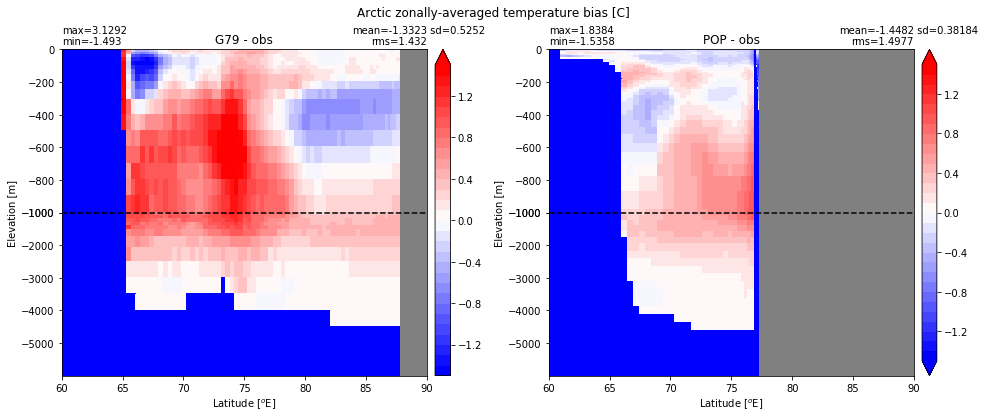

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Arctic zonally-averaged temperature bias [C]')
yzplot(np.ma.masked_invalid(mom_temp_arc.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$E', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-1.5, 1.5), centerlabels=True, splitscale=[0, -1000,-6000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(60,90)
yzplot(np.ma.masked_invalid(pop_temp_arc), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$E', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-1.5,1.5), centerlabels=True, splitscale=[0, -1000,-6000]) 
ax1[1].invert_yaxis(); ax1[1].set_xlim(60,90)

(60, 90)

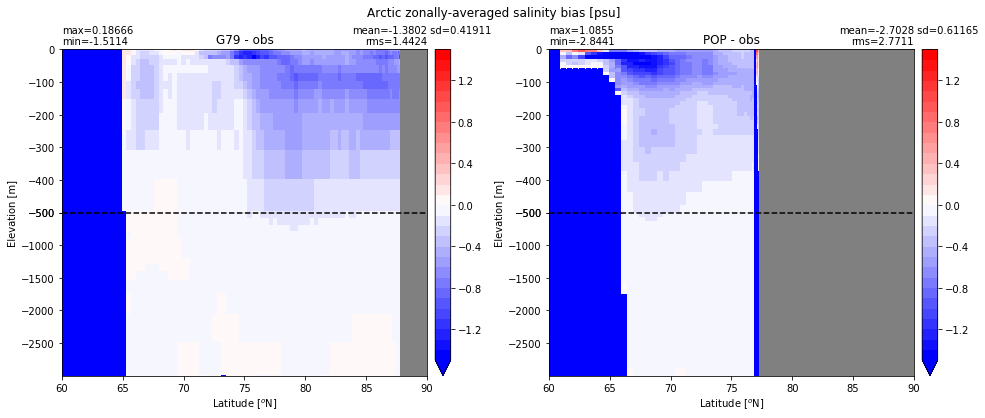

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1 = ax.flatten()
plt.suptitle('Arctic zonally-averaged salinity bias [psu]')
yzplot(np.ma.masked_invalid(mom_salt_arc.transpose()), ds_mom_t.yh.values, z_mom, ylabel='Latitude', yunits='$^o$N', title=str(labels[0]+' - obs'), 
       axis=ax1[0], nbins=30, colormap=plt.cm.bwr, clim=(-1.5, 1.5), centerlabels=True, splitscale=[0, -500,-3000])
ax1[0].invert_yaxis(); ax1[0].set_xlim(60,90)
yzplot(np.ma.masked_invalid(pop_salt_arc), grid.TLAT.mean('nlon'), z_pop, ylabel='Latitude', yunits='$^o$N', title='POP - obs', axis=ax1[1], 
       nbins=30, colormap=plt.cm.bwr, clim=(-1.5, 1.5), centerlabels=True, splitscale=[0, -500,-3000])
ax1[1].invert_yaxis(); ax1[1].set_xlim(60,90)

# Equatorial plots

### Temperature and Salinity

<center> <font size="4">Equatorial_Global_temperature</font></center>
<table><tr>
    <td><img  src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_Equatorial_Global_temperature.png'></td>
    <td>
    <img  src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_Equatorial_Global_salinity.png'></td>
    </tr>          
</table>

## Undercurrent

<center> <font size="4">Equatorial_Pacific_uo</font></center>
<table><tr><td><img src='../figures/g.c2b6.GJRA.TL319_t061.long_JRA_mct.079_Equatorial_Pacific_uo.png'></td></tr>
</table>

In [40]:
def get_data(full_path, variables):
  def preprocess(ds):
    ''' Return the dataset with variable'''
    return ds[variables]
  ds = xr.open_mfdataset(full_path, data_vars='minimal', \
                         coords='minimal', compat='override', preprocess=preprocess)
  return ds

In [41]:
variables=['uo','e']
ds = get_data(path+exps[0]+'/run/*mom6.hm_0058_*.nc',variables)

In [42]:
uo_mean = ds.uo.mean('time')
e_mean = ds.e.mean('time')

In [43]:
# check eastward vel. profile in the Equator during year 58
uo_mean_eq = uo_mean.sel(yh=0., method='nearest').sel(xq=-140., method='nearest').values 
e_mean_eq = e_mean.sel(yh=0., method='nearest').sel(xh=-140., method='nearest').values

(-1000, 0)

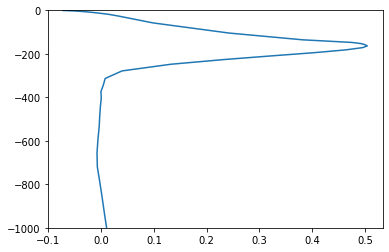

In [44]:
e_mean_eq_center = 0.5 * (e_mean_eq[0:-1]+e_mean_eq[1::])
plt.figure()
plt.plot(uo_mean_eq,e_mean_eq_center)
plt.ylim(-1000,0)

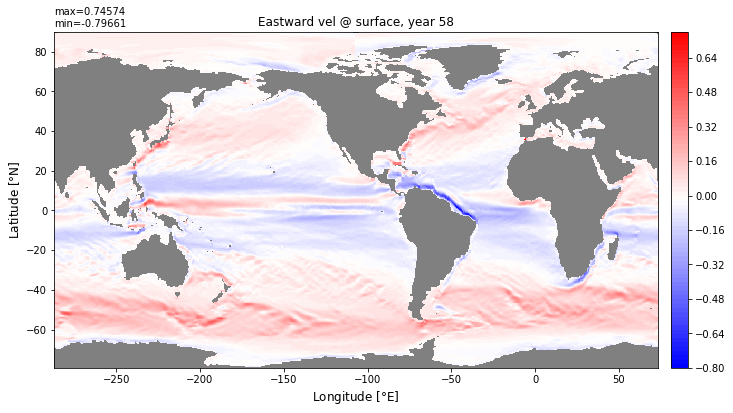

In [45]:
dummy = np.ma.masked_invalid(uo_mean[0,:].values)
xyplot(dummy, grd.geolon_u, grd.geolat_u, title='Eastward vel @ surface, year 58',  
      nbins=100, colormap=plt.cm.bwr)

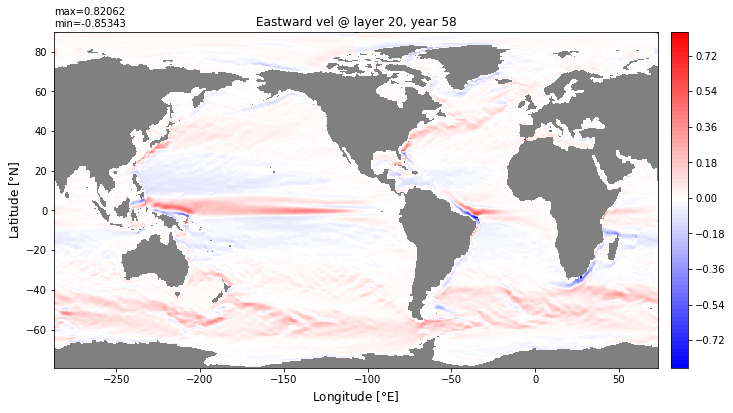

In [46]:
dummy = np.ma.masked_invalid(uo_mean[20,:].values)
xyplot(dummy, grd.geolon_u, grd.geolat_u, title='Eastward vel @ layer 20, year 58',  
      nbins=100, colormap=plt.cm.bwr)

# Horizontal Mean bias (w.r.t. obs) versus time

In [47]:
i=0
ds_mom = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
ds_mom.region

<xarray.DataArray 'region' (region: 11)>
array(['Global', 'MedSea', 'BalticSea', 'HudsonBay', 'Arctic', 'PacificOcean',
       'AtlanticOcean', 'IndianOcean', 'SouthernOcean', 'LabSea', 'BaffinBay'],
      dtype=object)
Coordinates:
  * region   (region) object 'Global' 'MedSea' ... 'LabSea' 'BaffinBay'

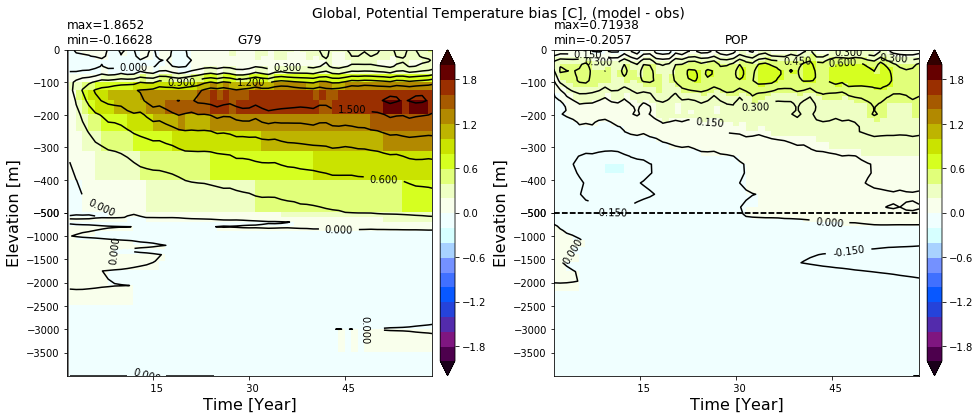

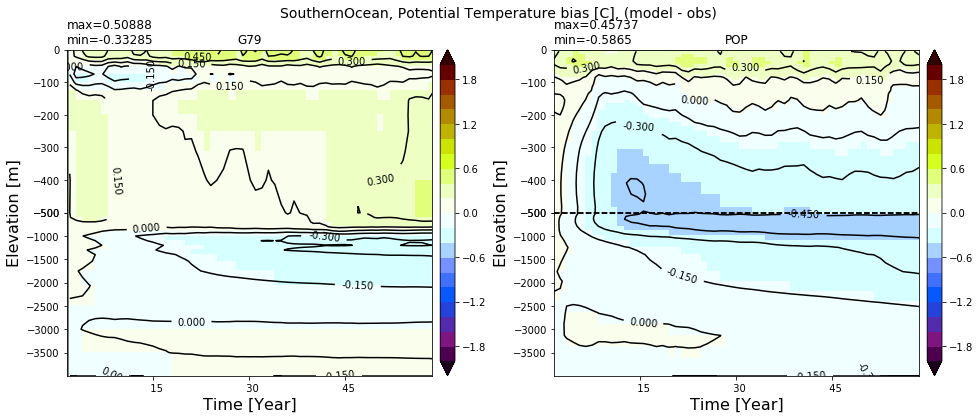

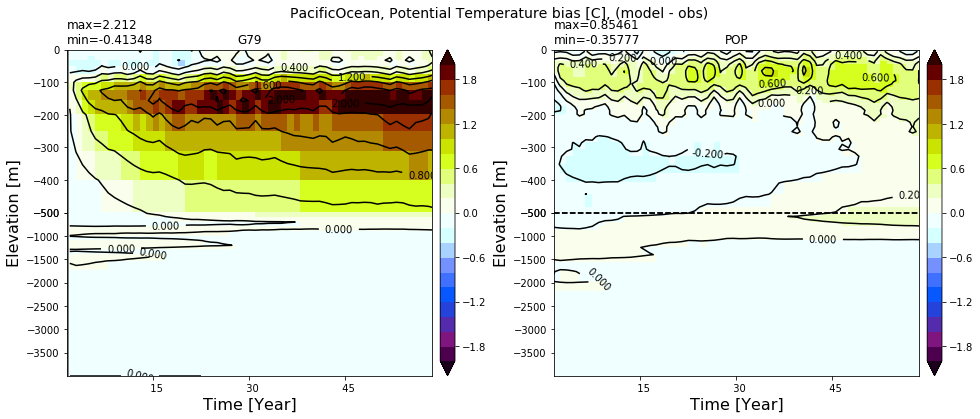

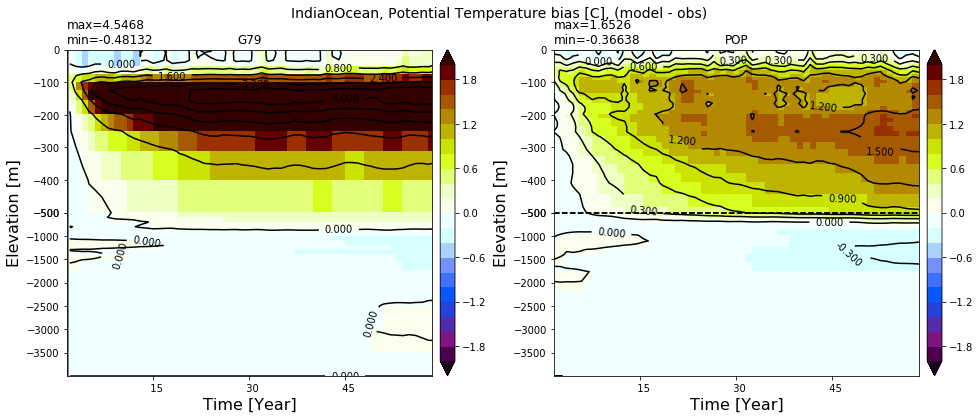

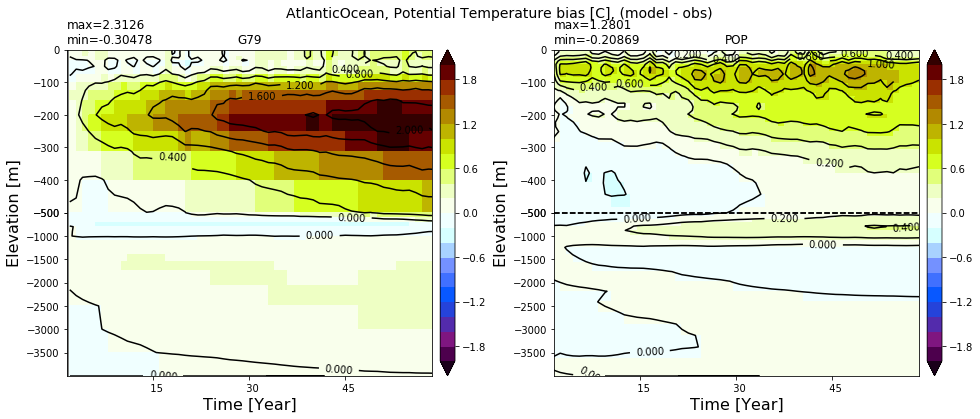

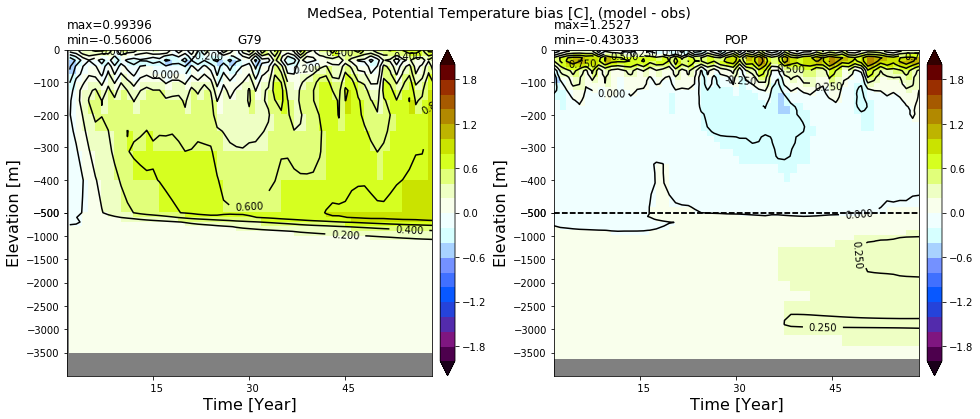

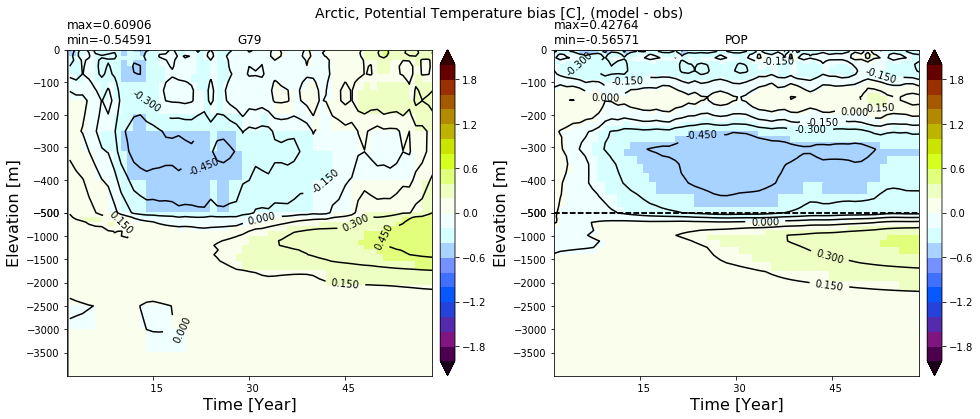

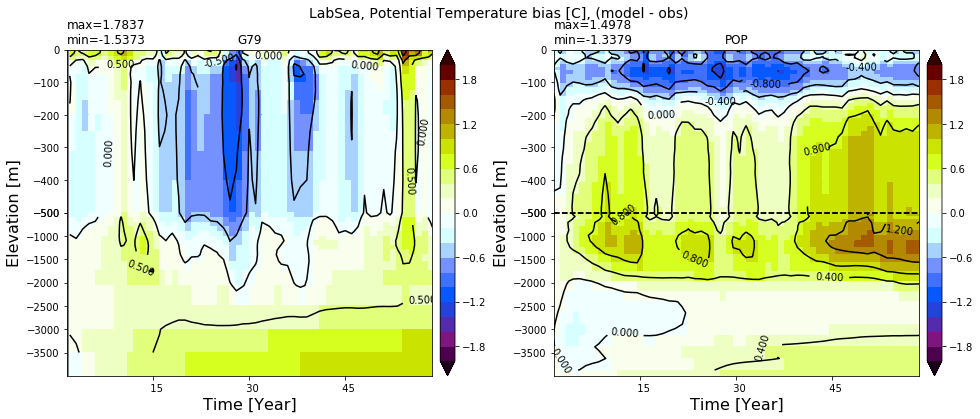

In [48]:
%matplotlib inline
reg_mom = ['Global','SouthernOcean','PacificOcean','IndianOcean','AtlanticOcean','MedSea','Arctic','LabSea']
reg_pop = [0,1,2,3,6,7,10,8]

ds_mom = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_temp_bias.nc').sel(time=slice('0001-01-01', '0058-12-31'))
ds_pop = xr.open_dataset('/glade/scratch/gmarques/g210.GIAF_JRA.v13.gx1v7.01_temp_bias.nc').sel(time=slice('0001-01-01', '0058-12-31'))
    
for m,p in zip(reg_mom,reg_pop):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
  plt.suptitle(str(m)+', Potential Temperature bias [C], (model - obs)', fontsize=14)
  splitscale =  [0., -500., -4000]
  dummy_mom = np.ma.masked_invalid(ds_mom.sel(region=m).__xarray_dataarray_variable__.values)
  dummy_pop = np.ma.masked_invalid(ds_pop.__xarray_dataarray_variable__.sel(region=str(p)).values)

  dummy_pop = np.ma.masked_invalid(ds_pop.sel(region=str(p)).__xarray_dataarray_variable__.values)

  ztplot(dummy_mom, ds_mom.time.values, ds_mom.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[0] ,
           title=labels[0], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-2, 2)) 
  ztplot(dummy_pop, ds_pop.time.values, -ds_pop.z_l.values/100., ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[1] ,
           title='POP', extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-2, 2))  

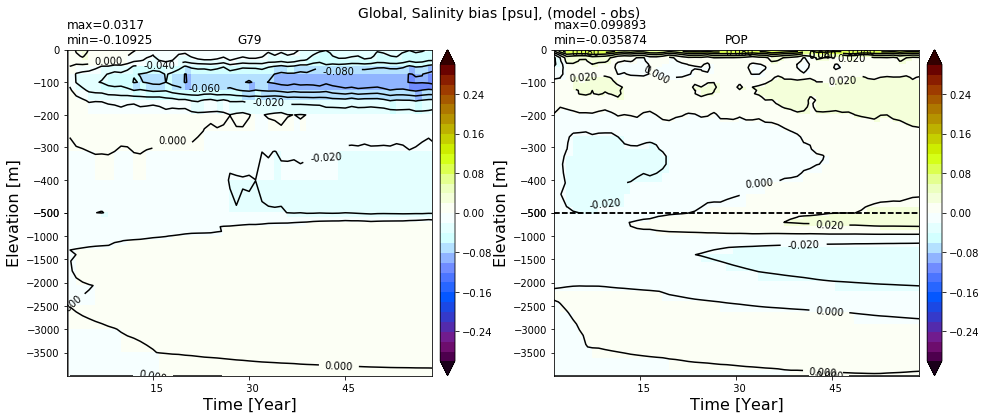

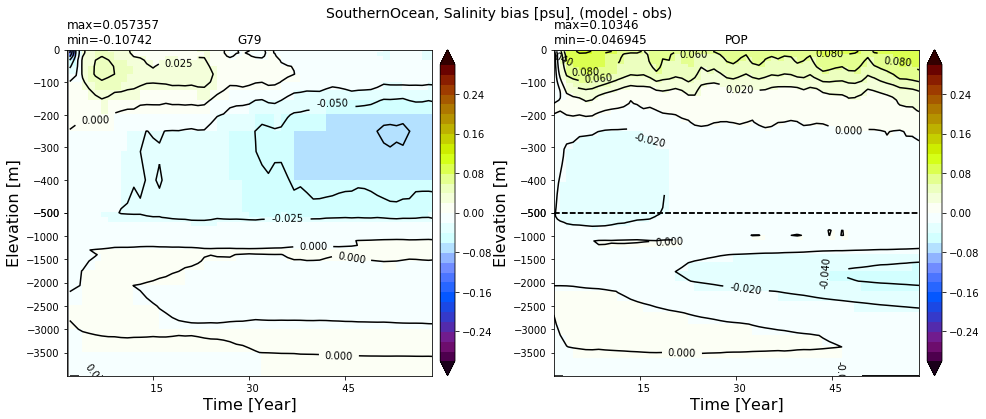

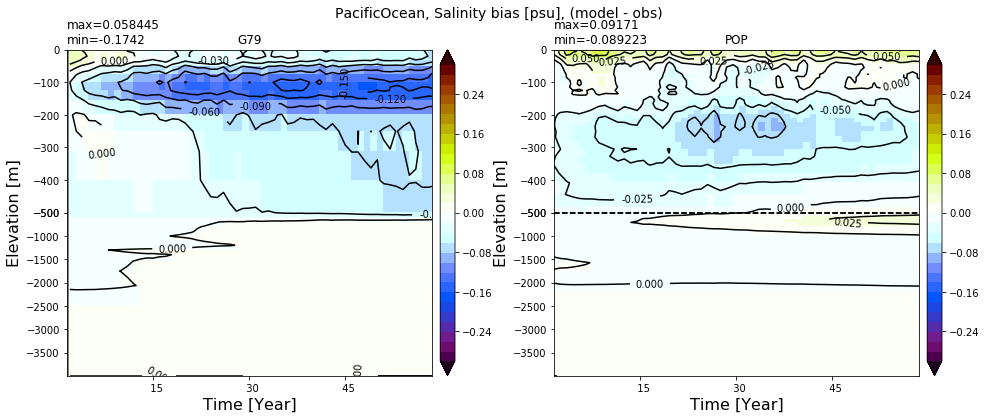

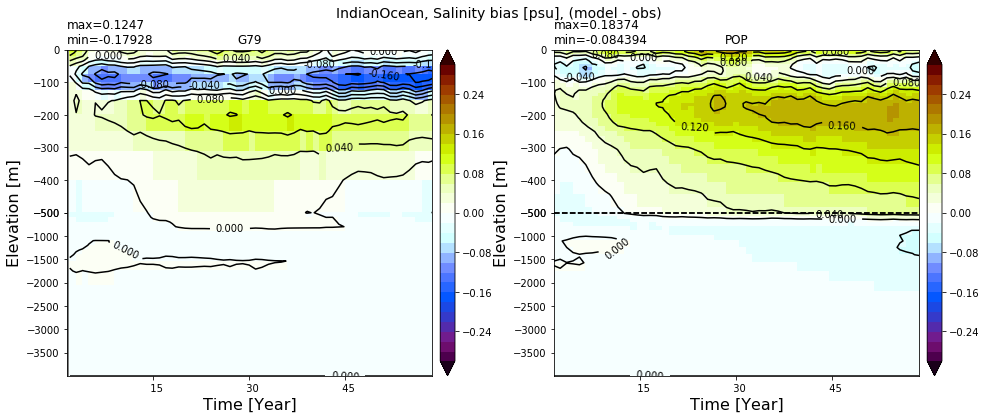

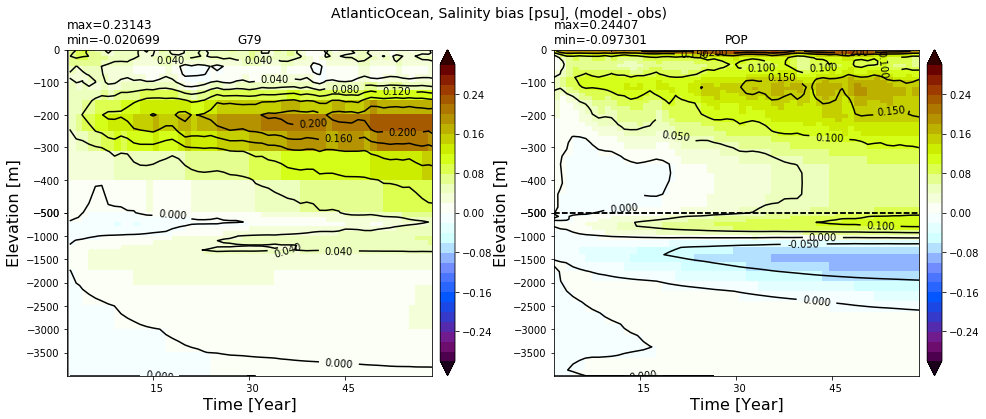

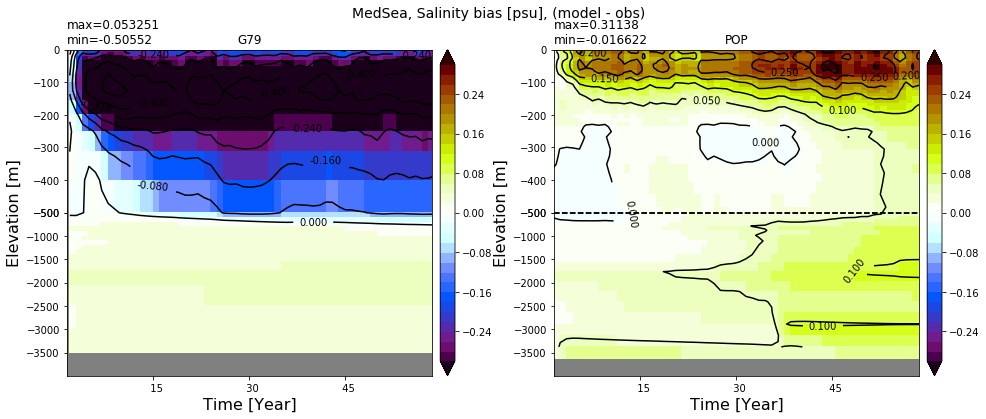

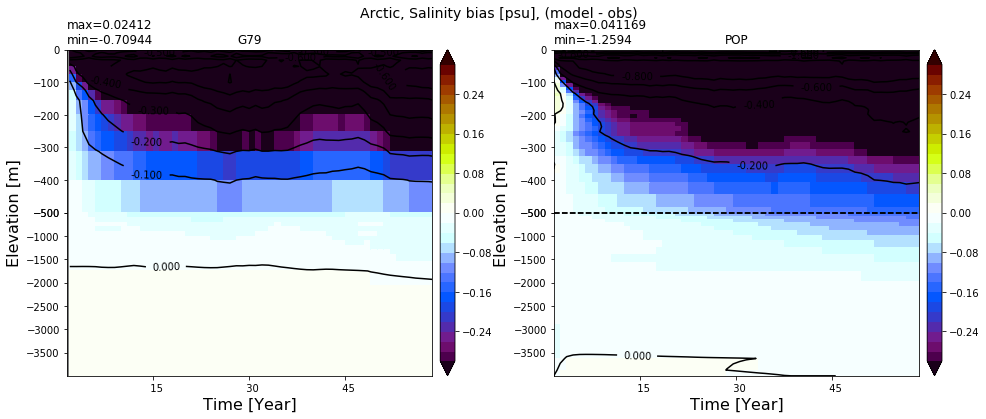

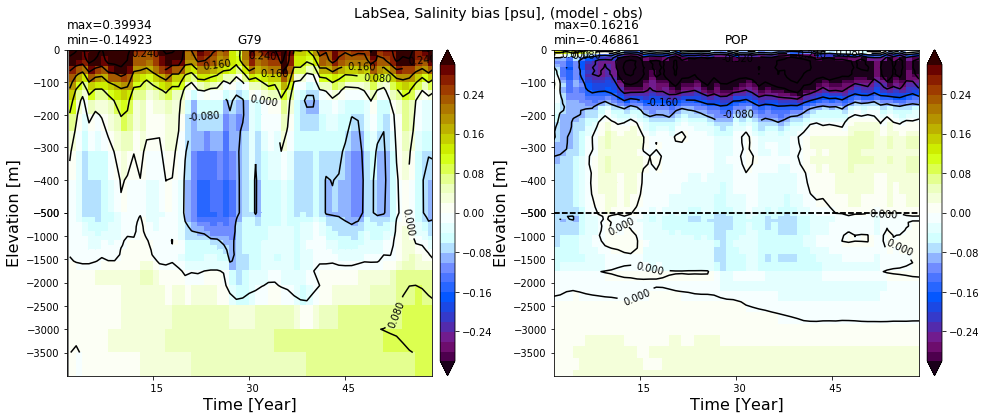

In [49]:
%matplotlib inline

ds_mom = xr.open_dataset('../../'+exps[0]+'/ncfiles/'+exps[0]+'_salt_bias.nc').sel(time=slice('0001-01-01', '0058-12-31'))
ds_pop = xr.open_dataset('/glade/scratch/gmarques/g210.GIAF_JRA.v13.gx1v7.01_salt_bias.nc').sel(time=slice('0001-01-01', '0058-12-31'))
        
for m,p in zip(reg_mom,reg_pop):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
  plt.suptitle(str(m)+', Salinity bias [psu], (model - obs)', fontsize=14)
  splitscale =  [0., -500., -4000]
  dummy_mom = np.ma.masked_invalid(ds_mom.sel(region=m).__xarray_dataarray_variable__.values)
  dummy_pop = np.ma.masked_invalid(ds_pop.__xarray_dataarray_variable__.sel(region=str(p)).values)

  dummy_pop = np.ma.masked_invalid(ds_pop.sel(region=str(p)).__xarray_dataarray_variable__.values)

  ztplot(dummy_mom, ds_mom.time.values, ds_mom.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[0] ,
           title=labels[0], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.3, 0.3)) 
  ztplot(dummy_pop, ds_pop.time.values, -ds_pop.z_l.values/100., ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[1] ,
           title='POP', extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.3, 0.3))  

# Mixing coefficients

In [50]:
def get_data_sf(full_path):
  ds = xr.open_dataset(full_path)
  return ds
variables = ['diftrblo', 'difmxylo' ,'difmxybo', 'diftrelo']

## GM (KHTH)

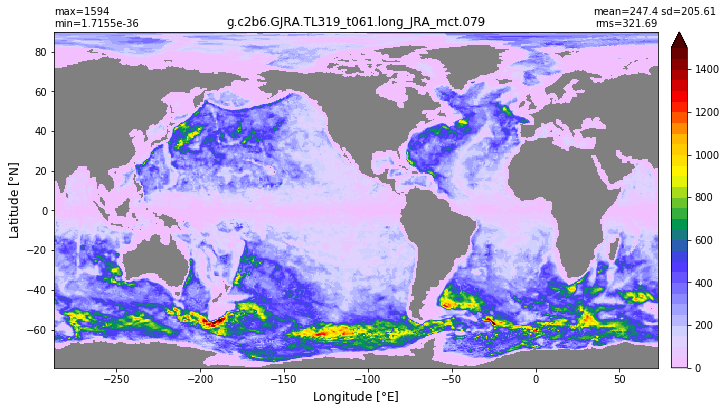

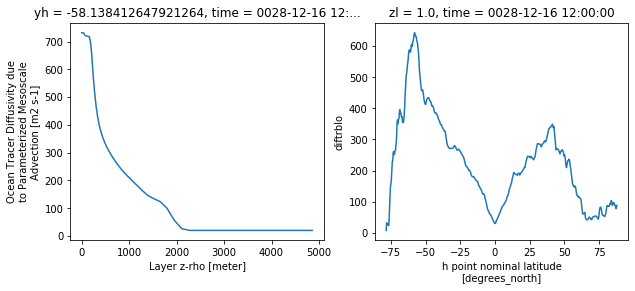

In [51]:
# GM coefficient
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0028_12.nc')
  xyplot(np.ma.masked_invalid(ds[variables[0]][0,0,:].values), grd.geolon, grd.geolat, area=grd.area_t, 
         clim=(0,1500), title=str(exps[exp]))
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
  ds[variables[0]][0,:,j,i].plot(ax=ax[0])
  ds[variables[0]][0,0,:,:].mean('xh').plot(ax=ax[1])

## Laplacian viscosity

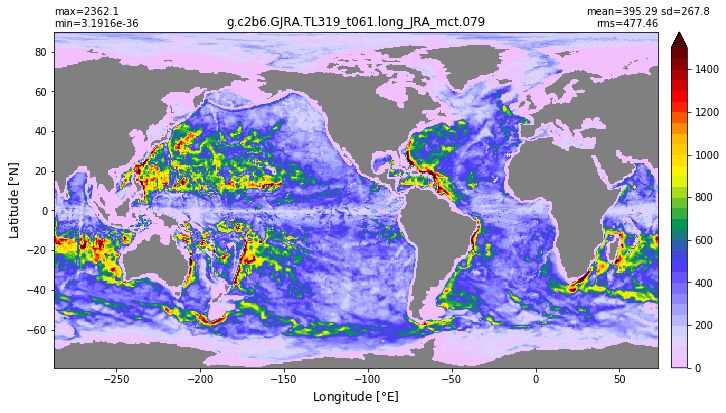

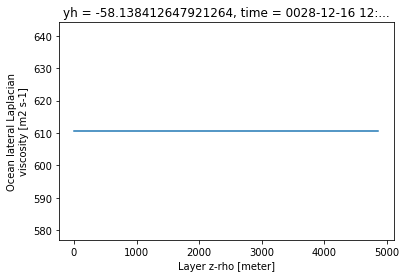

In [52]:
# Laplacian visc
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0028_12.nc')
  xyplot(np.ma.masked_invalid(ds[variables[1]][0,0,:].values), grd.geolon, grd.geolat, area=grd.area_t, clim=(0,1500), title=str(exps[exp]))
  f, ax = plt.subplots(1,1)
  ds[variables[1]][0,:,j,i].plot(ax=ax)

## Biharmonic viscosity

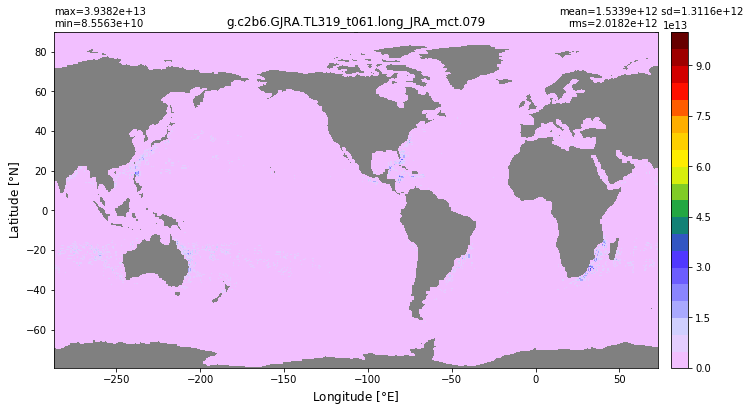

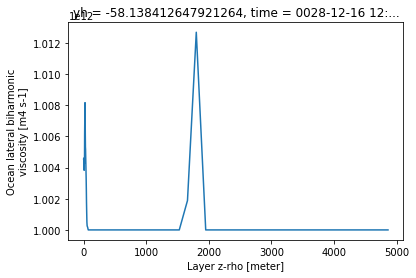

In [53]:
# Biharmonic
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0028_12.nc')
  xyplot(np.ma.masked_invalid(ds[variables[2]][0,0,:].values), grd.geolon, grd.geolat, area=grd.area_t, clim=(1.0e10,1.0e14), title=str(exps[exp]))
  f, ax = plt.subplots(1,1)
  ds[variables[2]][0,:,j,i].plot(ax=ax)

## Redi (KHTR)

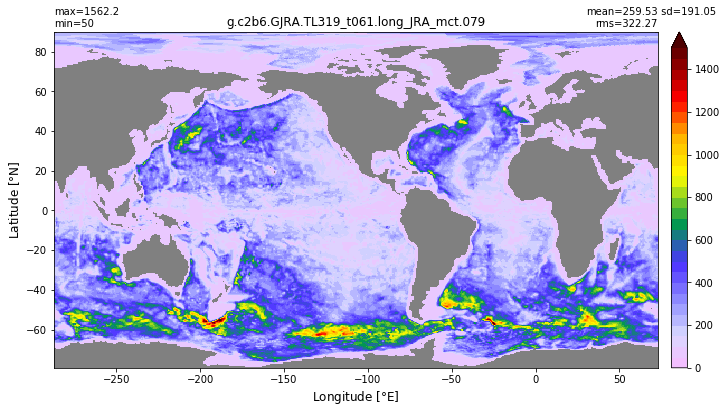

In [54]:
# KHTR (Redi)
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0028_12.nc')
  xyplot(np.ma.masked_invalid(ds[variables[3]][0,:].values), grd.geolon, grd.geolat, clim=(0, 1500), area=grd.area_t, title=str(exps[exp]))

### HyCOM coordinate system

In [40]:
ds = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/ocn/mom/tx0.66v1/hycom1_75_800m.nc')
ds

<xarray.Dataset>
Dimensions:  (interfaces: 76, layers: 75)
Dimensions without coordinates: interfaces, layers
Data variables:
    dz       (layers) float64 ...
    sigma2   (interfaces) float64 ...
Attributes:
    history:  Thu Jul  2 15:40:05 2020: ncatted -a author,global,m,c,Taken fr...
    NCO:      netCDF Operators version 4.7.9 (Homepage = http://nco.sf.net, C...

In [41]:
ds['sigma2'].values 

array([1010.    , 1014.3034, 1017.8088, 1020.843 , 1023.5566, 1025.813 ,
       1027.0275, 1027.9114, 1028.6422, 1029.2795, 1029.852 , 1030.3762,
       1030.8626, 1031.3183, 1031.7486, 1032.1572, 1032.5471, 1032.9207,
       1033.2798, 1033.6261, 1033.9608, 1034.2519, 1034.4817, 1034.6774,
       1034.8508, 1035.0082, 1035.1533, 1035.2886, 1035.4159, 1035.5364,
       1035.6511, 1035.7608, 1035.8661, 1035.9675, 1036.0645, 1036.1554,
       1036.2411, 1036.3223, 1036.3998, 1036.4739, 1036.5451, 1036.6137,
       1036.68  , 1036.7441, 1036.8062, 1036.8526, 1036.8874, 1036.9164,
       1036.9418, 1036.9647, 1036.9857, 1037.0052, 1037.0236, 1037.0409,
       1037.0574, 1037.0738, 1037.0902, 1037.1066, 1037.123 , 1037.1394,
       1037.1558, 1037.1722, 1037.1887, 1037.206 , 1037.2241, 1037.2435,
       1037.2642, 1037.2866, 1037.3112, 1037.3389, 1037.3713, 1037.4118,
       1037.475 , 1037.6332, 1037.8104, 1038.    ])

In [42]:
dz=ds['dz'].values 
dz

array([  2.  ,   2.  ,   2.  ,   2.  ,   2.  ,   2.  ,   2.  ,   2.  ,
         2.  ,   2.  ,   2.  ,   2.  ,   2.  ,   2.  ,   2.  ,   2.  ,
         2.  ,   2.  ,   2.  ,   2.  ,   2.01,   2.01,   2.01,   2.02,
         2.03,   2.05,   2.07,   2.09,   2.13,   2.18,   2.24,   2.32,
         2.42,   2.56,   2.73,   2.95,   3.23,   3.57,   3.99,   4.52,
         5.16,   5.95,   6.91,   8.06,   9.46,  11.13,  13.13,  15.5 ,
        18.32,  21.65,  25.56,  30.16,  35.54,  41.81,  49.1 ,  57.56,
        67.34,  78.63,  91.61, 106.51, 123.58, 143.08, 165.32, 190.61,
       219.33, 251.88, 288.68, 330.23, 377.05, 429.71, 488.84, 555.13,
       629.33, 712.25, 804.76])

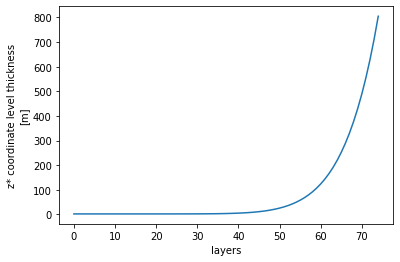

In [43]:
%matplotlib inline
ds['dz'].plot()

In [44]:
ds['dz'].cumsum()

<xarray.DataArray 'dz' (layers: 75)>
array([2.00000e+00, 4.00000e+00, 6.00000e+00, 8.00000e+00, 1.00000e+01,
       1.20000e+01, 1.40000e+01, 1.60000e+01, 1.80000e+01, 2.00000e+01,
       2.20000e+01, 2.40000e+01, 2.60000e+01, 2.80000e+01, 3.00000e+01,
       3.20000e+01, 3.40000e+01, 3.60000e+01, 3.80000e+01, 4.00000e+01,
       4.20100e+01, 4.40200e+01, 4.60300e+01, 4.80500e+01, 5.00800e+01,
       5.21300e+01, 5.42000e+01, 5.62900e+01, 5.84200e+01, 6.06000e+01,
       6.28400e+01, 6.51600e+01, 6.75800e+01, 7.01400e+01, 7.28700e+01,
       7.58200e+01, 7.90500e+01, 8.26200e+01, 8.66100e+01, 9.11300e+01,
       9.62900e+01, 1.02240e+02, 1.09150e+02, 1.17210e+02, 1.26670e+02,
       1.37800e+02, 1.50930e+02, 1.66430e+02, 1.84750e+02, 2.06400e+02,
       2.31960e+02, 2.62120e+02, 2.97660e+02, 3.39470e+02, 3.88570e+02,
       4.46130e+02, 5.13470e+02, 5.92100e+02, 6.83710e+02, 7.90220e+02,
       9.13800e+02, 1.05688e+03, 1.22220e+03, 1.41281e+03, 1.63214e+03,
       1.88402e+03, 2.17270e+03, 2.50293e+03, 2.87998e+03, 3.30969e+03,
       3.79853e+03, 4.35366e+03, 4.98299e+03, 5.69524e+03, 6.50000e+03])
Dimensions without coordinates: layers

In [45]:
ds = xr.open_dataset(path+exps[0]+'/run/'+exps[0]+'.mom6.hm_0058_12.nc')
ds

<xarray.Dataset>
Dimensions:           (nv: 2, scalar_axis: 1, time: 1, xh: 540, xq: 540, yh: 458, yq: 458, zi: 76, zl: 75)
Coordinates:
  * xq                (xq) float64 -286.3 -285.7 -285.0 ... 71.67 72.33 73.0
  * yh                (yh) float64 -79.2 -79.08 -78.95 ... 87.64 87.71 87.74
  * zl                (zl) float64 1.0 3.0 5.0 ... 3.338e+03 3.591e+03 4.861e+03
  * time              (time) object 0058-12-16 12:00:00
  * nv                (nv) float64 1.0 2.0
  * xh                (xh) float64 -286.7 -286.0 -285.3 ... 71.33 72.0 72.67
  * yq                (yq) float64 -79.14 -79.01 -78.89 ... 87.68 87.73 87.74
  * zi                (zi) float64 0.0 2.0 4.0 6.0 ... 3.461e+03 3.722e+03 6e+03
  * scalar_axis       (scalar_axis) float64 0.0
Data variables:
    uo                (time, zl, yh, xq) float32 ...
    vo                (time, zl, yq, xh) float32 ...
    h                 (time, zl, yh, xh) float32 ...
    e                 (time, zi, yh, xh) float32 ...
    thetao            (time, zl, yh, xh) float32 ...
    so                (time, zl, yh, xh) float32 ...
    rhopot0           (time, zl, yh, xh) float32 ...
    soga              (time, scalar_axis) float32 ...
    thetaoga          (time, scalar_axis) float32 ...
    uh                (time, zl, yh, xq) float32 ...
    vh                (time, zl, yq, xh) float32 ...
    vhbt              (time, yq, xh) float32 ...
    uhbt              (time, yh, xq) float32 ...
    oml               (time, yh, xh) float32 ...
    tauuo             (time, yh, xq) float32 ...
    tauvo             (time, yq, xh) float32 ...
    friver            (time, yh, xh) float32 ...
    prsn              (time, yh, xh) float32 ...
    prlq              (time, yh, xh) float32 ...
    evs               (time, yh, xh) float32 ...
    hfsso             (time, yh, xh) float32 ...
    rlntds            (time, yh, xh) float32 ...
    hfsnthermds       (time, yh, xh) float32 ...
    sfdsi             (time, yh, xh) float32 ...
    rsntds            (time, yh, xh) float32 ...
    hfds              (time, yh, xh) float32 ...
    ustar             (time, yh, xh) float32 ...
    hfsifrazil        (time, yh, xh) float32 ...
    wfo               (time, yh, xh) float32 ...
    ficeberg          (time, yh, xh) float32 ...
    fsitherm          (time, yh, xh) float32 ...
    hflso             (time, yh, xh) float32 ...
    pso               (time, yh, xh) float32 ...
    seaice_melt_heat  (time, yh, xh) float32 ...
    Heat_PmE          (time, yh, xh) float32 ...
    salt_flux_added   (time, yh, xh) float32 ...
    SSH               (time, yh, xh) float32 ...
    tos               (time, yh, xh) float32 ...
    sos               (time, yh, xh) float32 ...
    SSU               (time, yh, xq) float32 ...
    SSV               (time, yq, xh) float32 ...
    mass_wt           (time, yh, xh) float32 ...
    opottempmint      (time, yh, xh) float32 ...
    somint            (time, yh, xh) float32 ...
    Rd_dx             (time, yh, xh) float32 ...
    speed             (time, yh, xh) float32 ...
    mlotst            (time, yh, xh) float32 ...
    diftrelo          (time, yh, xh) float32 ...
    diftrblo          (time, zl, yh, xh) float32 ...
    difmxybo          (time, zl, yh, xh) float32 ...
    difmxylo          (time, zl, yh, xh) float32 ...
    volcello          (time, zl, yh, xh) float32 ...
    vmo               (time, zl, yq, xh) float32 ...
    vhGM              (time, zl, yq, xh) float32 ...
    vhml              (time, zl, yq, xh) float32 ...
    umo               (time, zl, yh, xq) float32 ...
    uhGM              (time, zl, yh, xq) float32 ...
    uhml              (time, zl, yh, xq) float32 ...
    agessc            (time, zl, yh, xh) float32 ...
    T_ady_2d          (time, yq, xh) float32 ...
    T_adx_2d          (time, yh, xq) float32 ...
    T_diffy_2d        (time, yq, xh) float32 ...
    T_diffx_2d        (time, yh, xq) float32 ...
    MEKE              (time, yh, xh) float32 ...
   

In [46]:
e = ds.e[0,:].sel(yh=0, method='nearest')
h = ds.h[0,:].sel(yh=0, method='nearest')

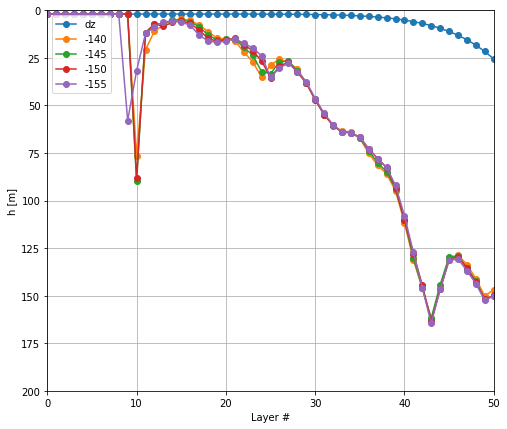

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
h140 = h.sel(xh=-140, method='nearest').values
h145 = h.sel(xh=-145, method='nearest').values
h150 = h.sel(xh=-150, method='nearest').values
h155 = h.sel(xh=-155, method='nearest').values

ax.plot(dz,'-o', label='dz')
ax.plot(h140,'-o', label='-140')
ax.plot(h145,'-o', label='-145')
ax.plot(h150,'-o', label='-150')
ax.plot(h155,'-o', label='-155')

ax.set_xlabel('Layer #')
ax.set_ylabel('h [m]')
ax.legend()
ax.set_xlim(0,50)
ax.set_ylim(0,200)
plt.gca().invert_yaxis()
plt.grid()

(-1000, 0)

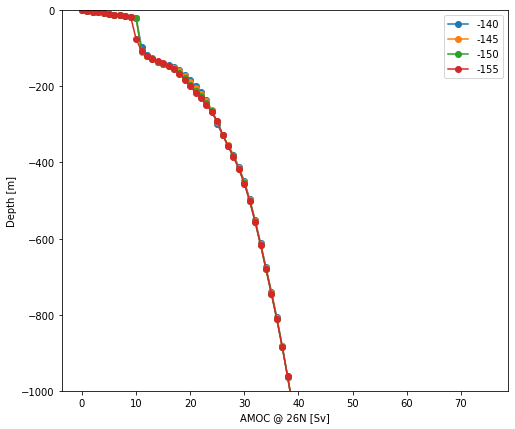

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
e140 = e.sel(xh=-140, method='nearest').values
e145 = e.sel(xh=-145, method='nearest').values
e150 = e.sel(xh=-150, method='nearest').values
e155 = e.sel(xh=-155, method='nearest').values


ax.plot(e140,'-o', label='-140')
ax.plot(e145,'-o', label='-145')
ax.plot(e150,'-o', label='-150')
ax.plot(e155,'-o', label='-155')

  #
  #plt.grid()
  
ax.set_xlabel('AMOC @ 26N [Sv]')
ax.set_ylabel('Depth [m]')
ax.legend()
ax.set_ylim(-1000,0)
#plt.gca().invert_yaxis()

#plt.plot(e.sel(xh=-140, method='nearest').values, '-o')